In [1]:
from functools import partial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from statsmodels.tsa.stattools import adfuller

# Constants

In [2]:
# Time Series Parameters
TIME_STEPS = 500

TREND_INTERCEPT = 3
CHANGE_POINTS = [1.0,]
GROWTH_RATES = [(0.01,0.1),]
SEASONALITY_PERIOD = 12

# SCALES
NOISE_SCALE = 5
TREND_SCALE = 3
SEASONALITY_SCALE = 5

# Display Parameters
WINDOWS = [12,]

# Visualization Functions

In [3]:
def get_rolling(series, window, function):
    rolling = []
    for idx in range(window, len(series)):
        rolling.append([idx,function(series[idx-window:idx])])
    return np.array(rolling)

def get_periodic(series, period, function):
    periodic = [function(series[idx::period]) for idx in range(period)]
    return np.resize(periodic, len(series))
    
def get_rolling_averaged(series, window):
    rolling = []
    weights = np.arange(window) ** 2
    for idx in range(window, len(series)):
        rolling.append([idx,np.average(series[idx-window:idx], weights=weights)])
    return np.array(rolling)

def percent_change(base, new):
    return 100 * ((new-base)/base)

def plot_series(series, scale=False):
    if(scale):
        series = (series - np.mean(series)) / np.std(series)
    
    fig, axs = plt.subplots(2,1,figsize=(18,6))
    axs[0].plot(np.arange(len(series)), series, label='series')
    for win in WINDOWS:
        data = get_rolling(series, win, np.mean)
        axs[0].plot(data[:,0], data[:,1], label=f'rolling-mean-{win}')
    for win in WINDOWS:
        data = get_rolling(series, win, np.std)
        axs[0].plot(data[:,0], data[:,1], label=f'rolling-std-{win}')
    axs[0].legend(loc='best')
    
    axs[1].hist(series, density=True, bins=40)  # density=False would make counts
    axs[1].set_ylabel('Probability')
    axs[1].set_xlabel('Data');
    
    plt.show()
    
    print(f'Average Mean {series.mean():.4f}')
    print(f'Average Variance {series.std():.4f}\n')
    
    third = int(len(series)*0.3333)
    base_mean = series[:third].mean()
    base_std = series[:third].std()
    print(f'Third 1 Mean {base_mean:.4f}, Std {base_std:.4f}')
    for idx in range(1,3):
        mean, std = series[third*idx:third*(idx+1)].mean(), series[third*idx:third*(idx+1)].std()
        print(f'Third {idx} Mean {mean:.4f} ({percent_change(base_mean,mean):.2f}% change), Std {std:.4f} ({percent_change(base_std,std):.2f}% change)')
    print("")
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
def display_series(series, title=None):
    fig, axs = plt.subplots(1,1,figsize=(18,4))
    axs.plot(np.arange(len(series)), series, label='series')
    if(title is not None):
        axs.set_title(title)
    axs.legend(loc='best')
    plt.show()

# What is A Time Series

A good way to think about this is how much money you might spend at the grocery store. As time goes on you might develop more expensive tastes or your kids might become teanagers, all of which will likely change the overall average amount of money you spend on groceries. This overall average changing can be thought of as the trend.

Now say you really like running big family barbecues. A lot of fun, but feeding all those people can get expensive and add to the grocery bill. Since barbecues tend to happen in the summers (at least if you live somewhere with cold winters) you will tend to spend more money in the summer seasons than in the winter ones. This is the season effect of your speding habbits.

Finally there is the white noise. Sometimes you go to the grocery store and you pick up an extra item, sometimes you need less items, sometimes there is a sale, sometimes only the expensive meat is left. You can't really predict a few bucks on your grocery bill since there is just too much random variability in these things. This means if we were trying to forecast your grocery spending we would try and learn the trend and seasonality, but we might ignore the random noise.

# Generate Time Series Components

## Generate Noise

Noise is the component to a time series that we cannot forecast. Noise is the random fluctuations in a time series that don't follow any pattern and are not correlated to any other effects. White noise is just random fluctuations that follow a normal distribution. When forecasting we will try and forecast the trend and seasonality in a time series, but we won't can't forecast the white noise. The best we can do is to use this white noise to define the scale of our uncertainty.

### Additive Noise

Additive noise can be centered around zero, it gets added to the trend and seasonality to create the random variability in the time series.

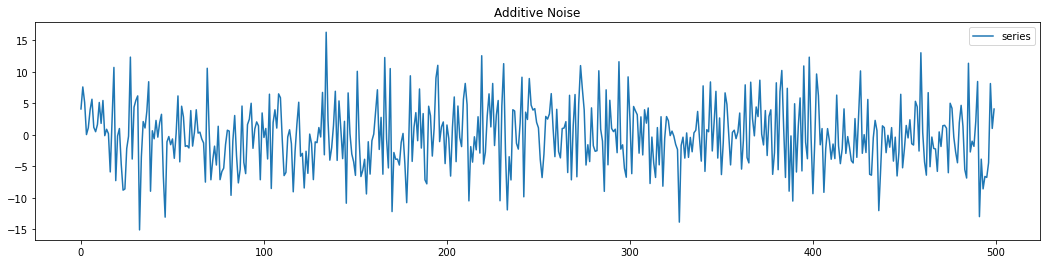

In [4]:
ADDITIVE_NOISE = np.random.normal(loc=0.0, scale=NOISE_SCALE, size=TIME_STEPS)
display_series(ADDITIVE_NOISE, title="Additive Noise")

### Multiplicative Noise

Multiplicative noise gets multiplied to the trend and seasonality to generate the time series, this means that noise will have an increasing effect depending on the scale of the seasonality and trends absolute value.

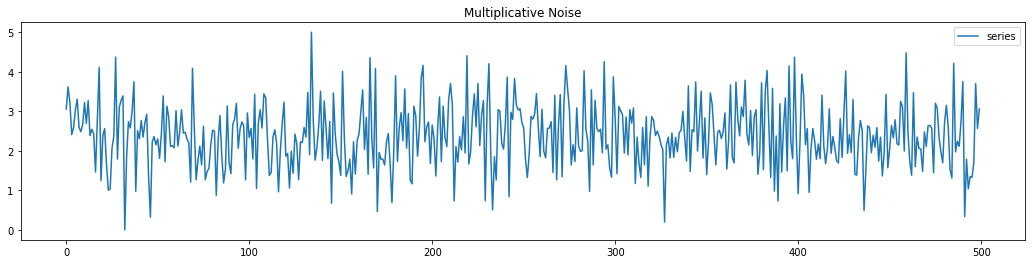

In [5]:
MULTIPLICATIVE_NOISE = MinMaxScaler(feature_range=(0,NOISE_SCALE)).fit_transform(ADDITIVE_NOISE.reshape((-1,1))).flatten()
display_series(MULTIPLICATIVE_NOISE, title="Multiplicative Noise")

## Generate Trend

The trend is the direction that the time series is moving. A good way to think about this is through growth rates. At different points in time a time series may be growing or contracting by different levels. If a product is being bought less and less than the growth rate might be -2 where each time step we expect there to be 2 less products sold than if this growth rate was not applied.

Here we will work with only one growth rate, but in the future we will play around with some techniques to normalize a series that has changepoints where the growthrate varies.

The trend is created when an intercept is added to the growth rates. if we have a line such that y = 10x + 2 then we know the growth rate is 10 and the intercept is 2 making the trend line of the series. 

An important note is that growth rates may vary with time. We will add methods to account for that here. Think of this as the orders for the new iphone. The orders will increase as more ads go out and more people see their friends with them, but once the next phone is announced the growth rate will likely go negative as less people are buying a phone when a new one is going to be released soon. An important note is that even though the growth rates are negative, the sales are still positive, it just means that there are less and less expected sales over time.

### Additive Linear Trend

In this case the trend is added to the rest of the series. The trend is linear becuase the slope of the line is always a constant, this constant may change (since the slope is just the growth rate) but the growth rate will always be some single constant value.

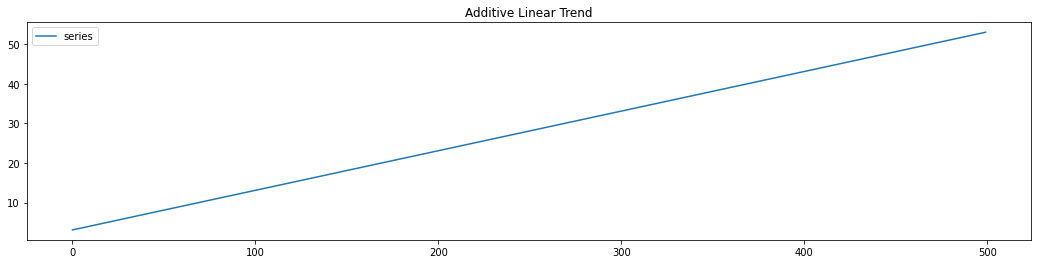

In [6]:
trend = []
last_value = 0
for x in np.arange(TIME_STEPS):
    change_point_found = False
    for change_idx, change_point in enumerate(CHANGE_POINTS):
        if(x < change_point*TIME_STEPS):
            trend.append(last_value + GROWTH_RATES[change_idx][1])
            last_value = last_value + GROWTH_RATES[change_idx][1]
            change_point_found = True
            break
    if(not change_point_found):
        raise Exception('No growth rate found for x value of ', x)
            
ADDITIVE_LINEAR_TREND = np.array(trend) + TREND_INTERCEPT
display_series(ADDITIVE_LINEAR_TREND, title="Additive Linear Trend")

### Additive Exponential Trend

This is the same as the linear trend except that surprise surprise, the trend is non linear, here we have an exponential component so the trend follows the format y = ax^2 + bx + c.

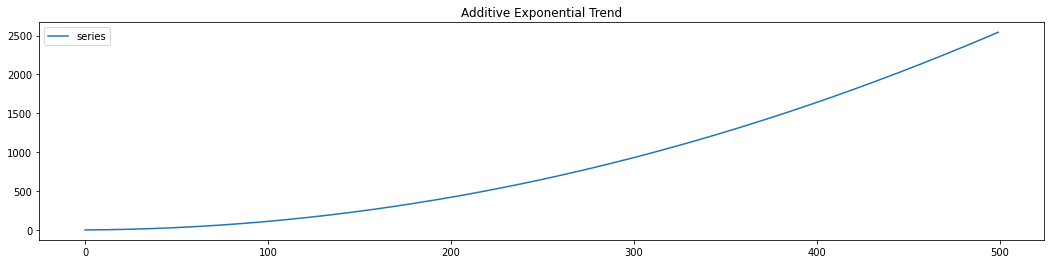

In [7]:
trend = []
for x in np.arange(TIME_STEPS):
    change_point_found = False
    for change_idx, change_point in enumerate(CHANGE_POINTS):
        if(x < change_point*TIME_STEPS):
            trend.append(((x**2)*GROWTH_RATES[change_idx][0])+(x*GROWTH_RATES[change_idx][1]))
            change_point_found = True
    if(not change_point_found):
        raise Exception('No growth rate found for x value of ', x)
            
ADDITIVE_EXPONENTIAL_TREND = np.array(trend) + TREND_INTERCEPT
display_series(ADDITIVE_EXPONENTIAL_TREND, title="Additive Exponential Trend")

### Multiplicative Linear Trend

This works the same as the additive trend, but we multiply here, for this reason we will be scalling the values. It will follow the same shape as the additive linear trend but we scale the values so we dont multiply by values that are too large.

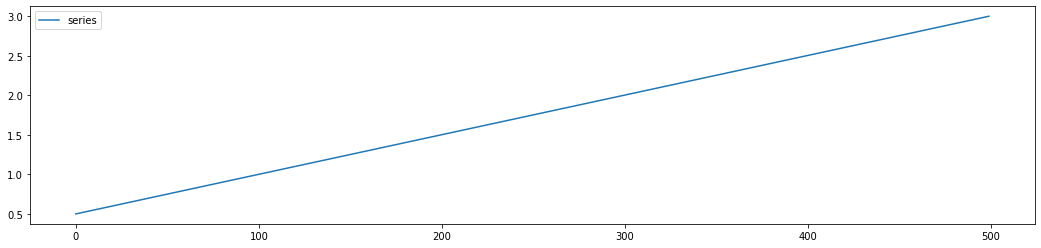

In [8]:
MULTIPLICATIVE_LINEAR_TREND = MinMaxScaler(feature_range=(0.5,TREND_SCALE)).fit_transform(ADDITIVE_LINEAR_TREND.reshape((-1,1))).flatten()
display_series(MULTIPLICATIVE_LINEAR_TREND)

### Multiplicative Exponential Trend

This works the same as the exponential trend, but we multiply here, for this reason we will be scalling the values. It will follow the same shape as the additive exponential trend but we scale the values so we dont multiply by values that are too large.

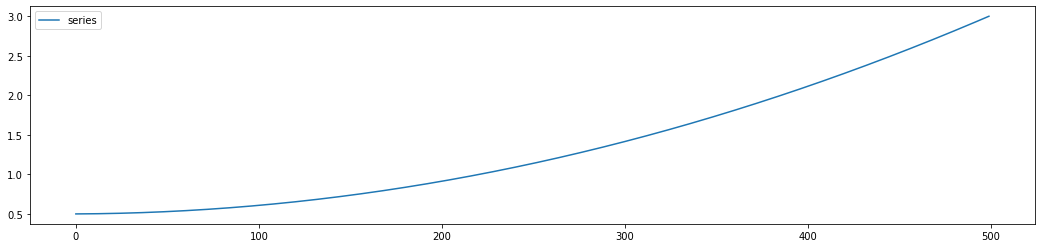

In [9]:
MULTIPLICATIVE_EXPONENTIAL_TREND = MinMaxScaler(feature_range=(0.5,TREND_SCALE)).fit_transform(ADDITIVE_EXPONENTIAL_TREND.reshape((-1,1))).flatten()
display_series(MULTIPLICATIVE_EXPONENTIAL_TREND)

## Generate Seasonality

The seasonality is a periodic effect on the expected value of our time series. As an example we expect ice cream sales to increase in the summer and decrease in the winter. These seasonal effects are important for modeling the behaviour of the time series.

Going back to the ice cream example, we can see why seasonality is important. If we want to see if the amount of ice cream people are consuming is increasing or decreasing as a whole (the growth rate at a specific time point) and we don't account for seasonality we might get the wrong idea (saying its decreasing in the fall and increasing in the spring) when in reality we expect changes in these seasons anyways.

### Additive Seasonality

Additive seasonality adds to the time series. This means that it has a constant effect on the time series depending on the magnitude of the additive value.

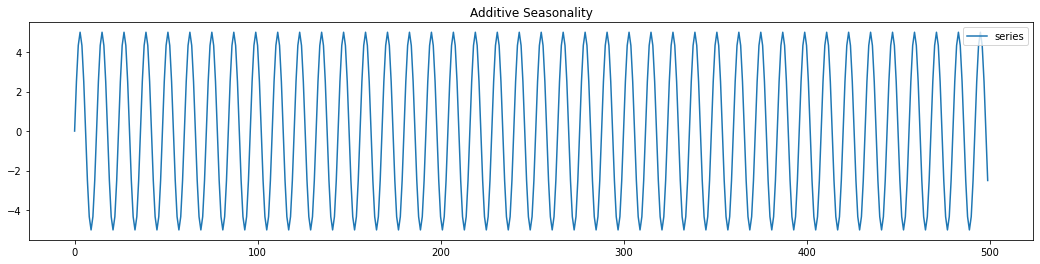

In [10]:
ADDITIVE_SEASONALITY = np.sin((2*np.arange(TIME_STEPS)/SEASONALITY_PERIOD)*np.pi) * SEASONALITY_SCALE
display_series(ADDITIVE_SEASONALITY, title="Additive Seasonality")

### Multiplicative Seasonality

This works the same as additive seasonality except it is multiplied to the time series. For this reason we will scale the effect to make it more reasonable.

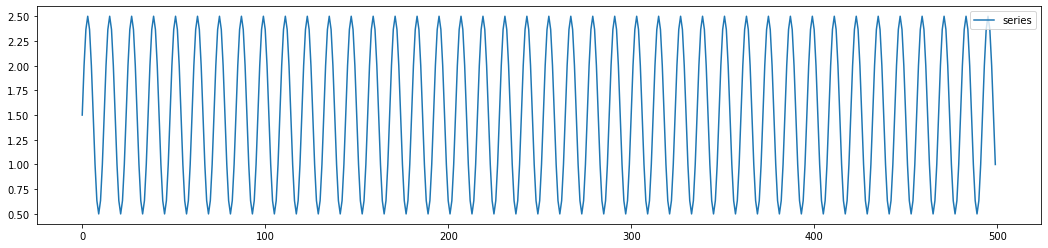

In [11]:
MULTIPLICATIVE_SEASONALITY = MinMaxScaler(feature_range=(0.5,SEASONALITY_SCALE/2)).fit_transform(ADDITIVE_SEASONALITY.reshape((-1,1))).flatten()
display_series(MULTIPLICATIVE_SEASONALITY)

# Linear Trend Time Series

## Additive

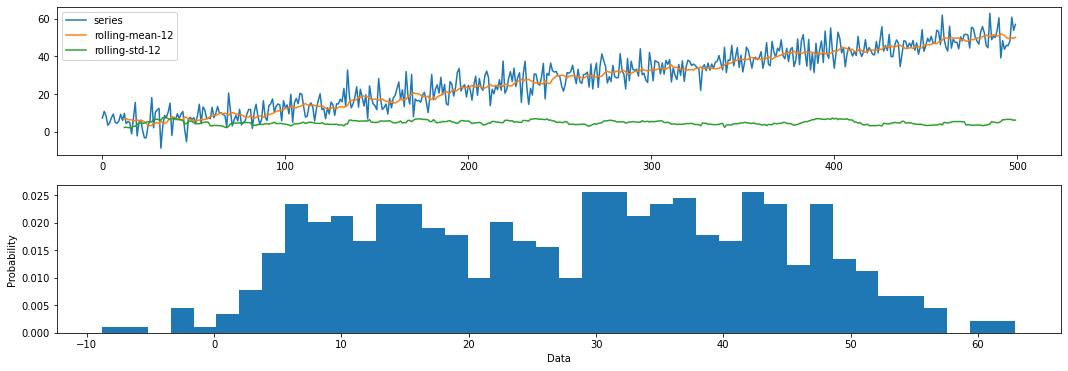

Average Mean 27.9043
Average Variance 15.2823

Third 1 Mean 10.8658, Std 6.4743
Third 1 Mean 28.1494 (159.06% change), Std 7.0141 (8.34% change)
Third 2 Mean 44.3653 (308.30% change), Std 6.4656 (-0.13% change)

Results of Dickey-Fuller Test:
Test Statistic                  -0.240449
p-value                          0.933525
#Lags Used                      15.000000
Number of Observations Used    484.000000
Critical Value (1%)             -3.443933
Critical Value (5%)             -2.867530
Critical Value (10%)            -2.569961
dtype: float64


In [12]:
additive_linear_trend_series = ADDITIVE_NOISE + ADDITIVE_LINEAR_TREND
plot_series(additive_linear_trend_series)

### Removing the Rolling Mean

The first normalization technique we will look at is removing the rolling mean. This is basically using a window of a dynamic length, determining the average value in this window, and subtracting the series by that value. Because the mean value lags the actual value by the growth rate over the period of time, the series will not be centered around zero. However because we have a linear trend we will be wrong by the same amount at each point, meaning the series will still be stationary, but around some non-zero constant point. This is good becuase a simple standard scaler can take us the rest of the way.

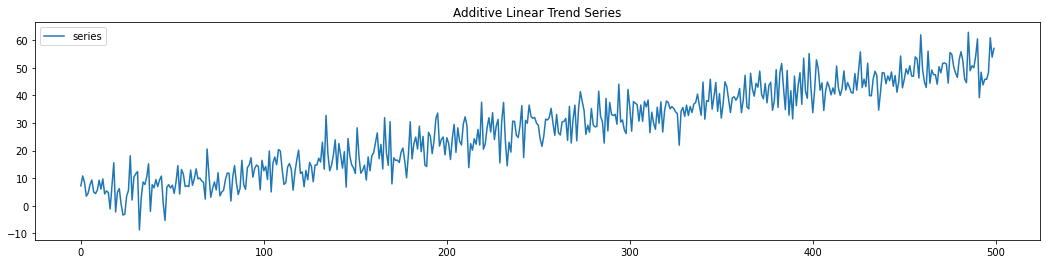

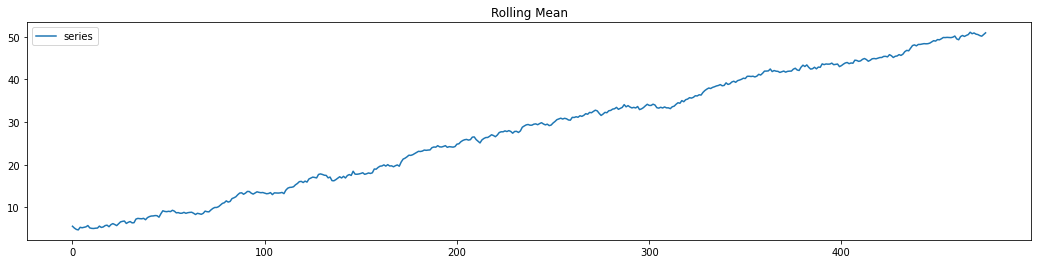

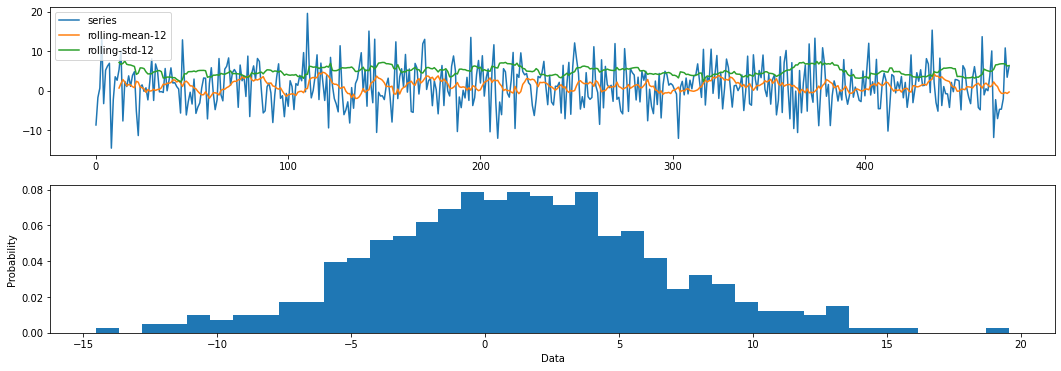

Average Mean 1.2187
Average Variance 5.2558

Third 1 Mean 1.1171, Std 5.4129
Third 1 Mean 1.2757 (14.20% change), Std 5.1631 (-4.61% change)
Third 2 Mean 1.2181 (9.05% change), Std 5.2022 (-3.89% change)

Results of Dickey-Fuller Test:
Test Statistic                 -23.338732
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    475.000000
Critical Value (1%)             -3.444192
Critical Value (5%)             -2.867644
Critical Value (10%)            -2.570021
dtype: float64


In [13]:
display_series(additive_linear_trend_series, title="Additive Linear Trend Series")
window = 24
trend = get_rolling(additive_linear_trend_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = additive_linear_trend_series[window:] - trend[:,1]
plot_series(detrended_series)

### Removing the Weighted Rolling Mean

Here we will do the same thing as before, and it should work for the same reason. The only difference is that here we will be using a weighting when taking the mean value that prioritizes the most recent points in time over the less recent.

Remember that in this rolling mean methodology we are looking at the last N days, the reason we look backwards is so that this technique could actually be applied to forecasting going forward, we don't rely on any future knowledge. This means we skew the data less, but we still have some skew since we do not account for the entire trend.

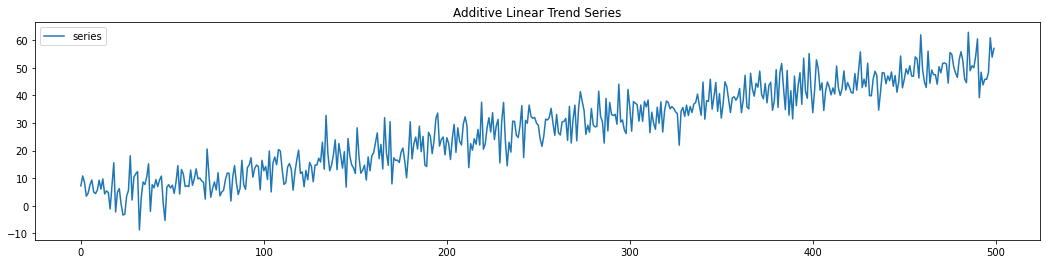

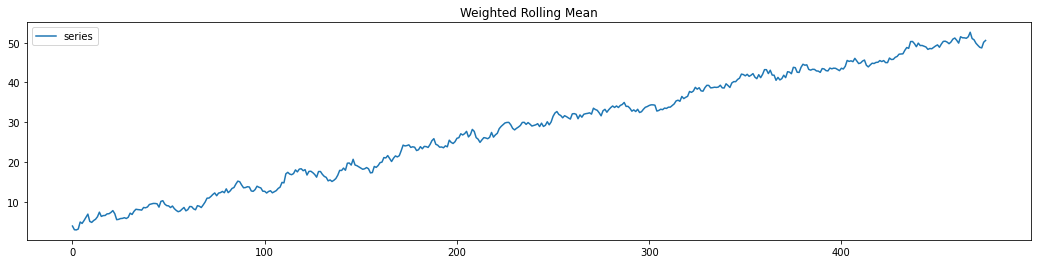

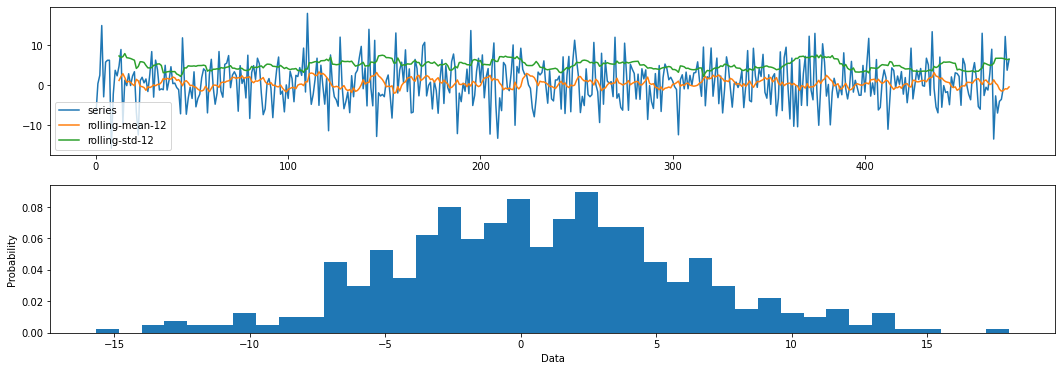

Average Mean 0.6484
Average Variance 5.3501

Third 1 Mean 0.6206, Std 5.4476
Third 1 Mean 0.6771 (9.11% change), Std 5.2855 (-2.98% change)
Third 2 Mean 0.5901 (-4.92% change), Std 5.3229 (-2.29% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.033541e+01
p-value                        2.772329e-18
#Lags Used                     7.000000e+00
Number of Observations Used    4.680000e+02
Critical Value (1%)           -3.444400e+00
Critical Value (5%)           -2.867736e+00
Critical Value (10%)          -2.570070e+00
dtype: float64


In [14]:
display_series(additive_linear_trend_series, title="Additive Linear Trend Series")
window = 24
trend = get_rolling_averaged(additive_linear_trend_series, window)
display_series(trend[:,1], title="Weighted Rolling Mean")
detrended_series = additive_linear_trend_series[window:] - trend[:,1]
plot_series(detrended_series)

### Differencing the Series

The technique of differencing is pretty simple, rather than looking at a time series as a range of values, differencing is just looking at the time series as the change from one time step to another. Say we had the series 1, 3, 5, 1 well the differenced series would be 2, 2, -4.

Differencing works becuase while a time series may have general overall trends and changes, the day to day volatility will tend to be normally distributed. If we model that day to day volatility instead we will have nicer data. The other advantage is that it makes a little more sense to model how a time series increases or decreases in response to different signal, rather than just predicting absolute values of the time series.

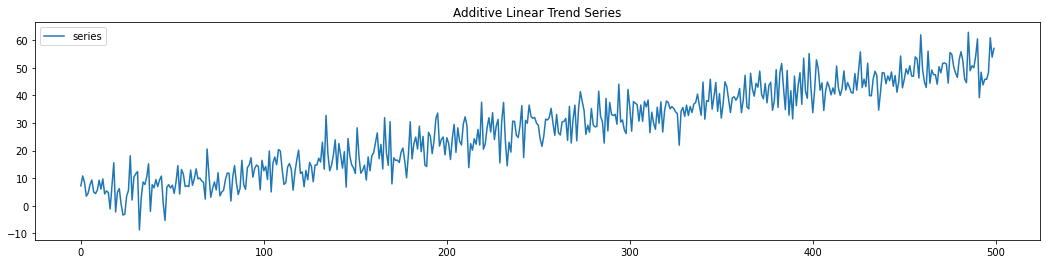

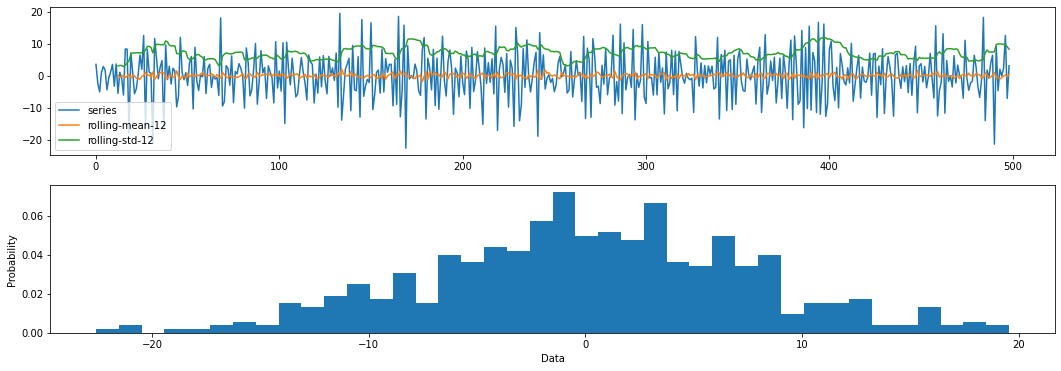

Average Mean 0.1000
Average Variance 7.4141

Third 1 Mean 0.1491, Std 7.0442
Third 1 Mean 0.0046 (-96.91% change), Std 7.6982 (9.28% change)
Third 2 Mean 0.1276 (-14.41% change), Std 7.5025 (6.51% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.046947e+01
p-value                        1.295621e-18
#Lags Used                     1.400000e+01
Number of Observations Used    4.840000e+02
Critical Value (1%)           -3.443933e+00
Critical Value (5%)           -2.867530e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


In [15]:
display_series(additive_linear_trend_series, title="Additive Linear Trend Series")
differenced_series = np.diff(additive_linear_trend_series, 1)
plot_series(differenced_series)

## Multiplicative

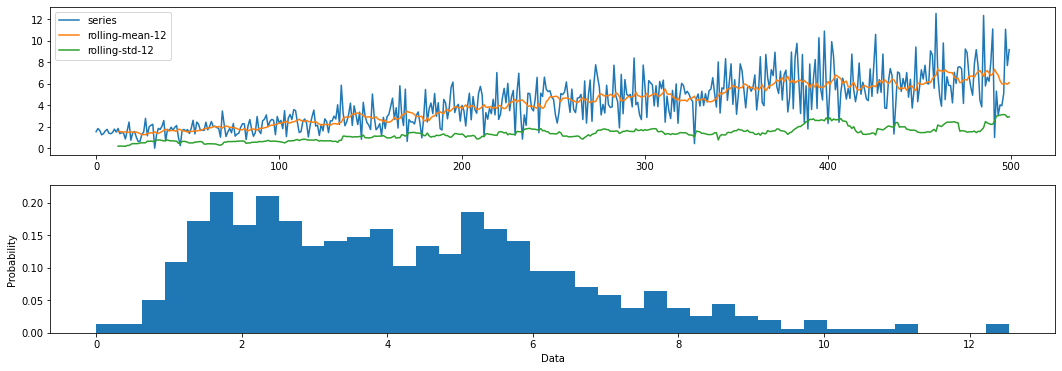

Average Mean 4.1645
Average Variance 2.2860

Third 1 Mean 2.1025, Std 0.8939
Third 1 Mean 4.2434 (101.83% change), Std 1.5418 (72.48% change)
Third 2 Mean 6.0962 (189.95% change), Std 2.0854 (133.29% change)

Results of Dickey-Fuller Test:
Test Statistic                  -1.100822
p-value                          0.714744
#Lags Used                      15.000000
Number of Observations Used    484.000000
Critical Value (1%)             -3.443933
Critical Value (5%)             -2.867530
Critical Value (10%)            -2.569961
dtype: float64


In [16]:
multiplicative_linear_trend_series = MULTIPLICATIVE_NOISE * MULTIPLICATIVE_LINEAR_TREND
plot_series(multiplicative_linear_trend_series)

### Removing the Rolling Mean

We will again look at removing the rolling mean here, as you can see in this case this is not very effective. The reason for this is that as the trend increases the effect of the random noise increases as they are multiplied together, this means that there is a correlation between the series variance and time. This means that we do not infact have a stationary time series.

For this reason we get increasing variance over time. We need a method to standardize the variance over time, and remove the effect of the increasing variance. We can do this by dividing by the rolling variance after we remove the trend from the time series. This is one way to get a stationary time series.

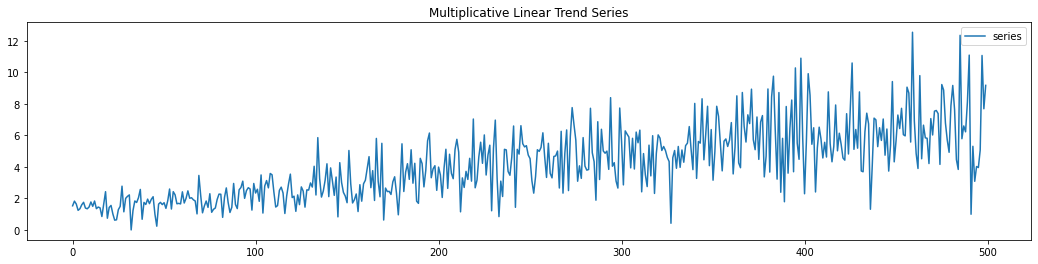

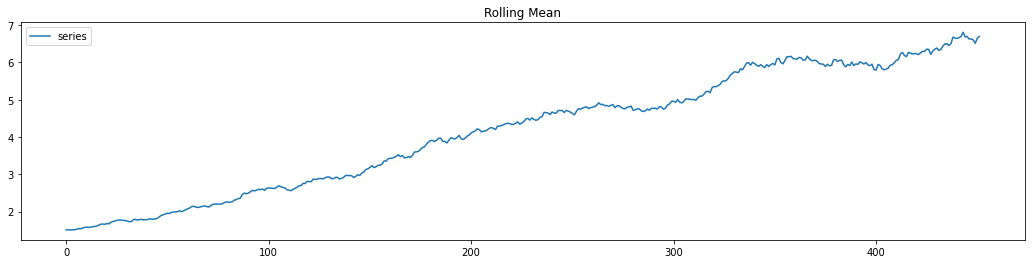

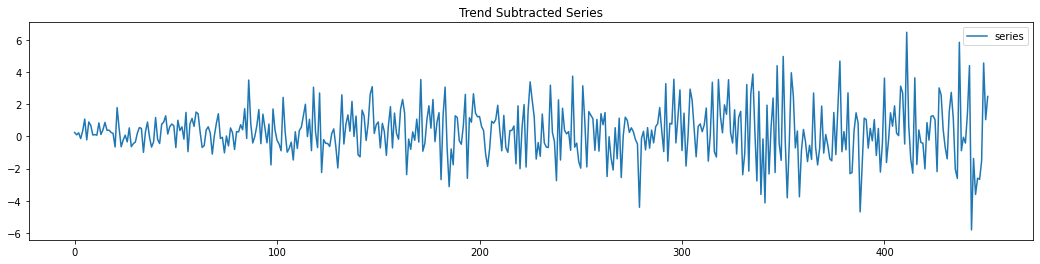

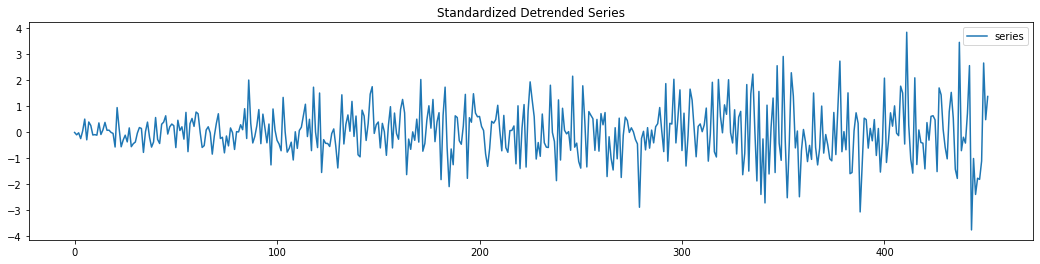

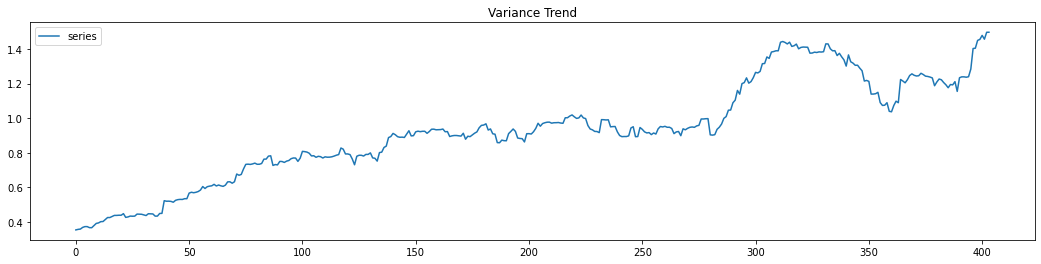

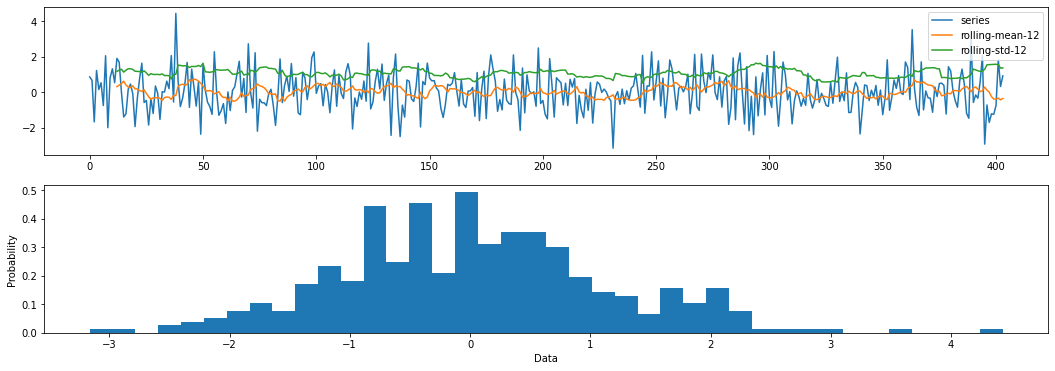

Average Mean 0.0298
Average Variance 1.1245

Third 1 Mean 0.0943, Std 1.1779
Third 1 Mean 0.0056 (-94.07% change), Std 1.0425 (-11.49% change)
Third 2 Mean -0.0191 (-120.25% change), Std 1.1510 (-2.28% change)

Results of Dickey-Fuller Test:
Test Statistic                 -22.115828
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    403.000000
Critical Value (1%)             -3.446681
Critical Value (5%)             -2.868739
Critical Value (10%)            -2.570605
dtype: float64


In [17]:
# display the initial series
display_series(multiplicative_linear_trend_series, title="Multiplicative Linear Trend Series")
window = 48
# remove the trend
trend = get_rolling(multiplicative_linear_trend_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = multiplicative_linear_trend_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# remove the rolling variance
detrended_series = (detrended_series - np.mean(detrended_series))/np.std(detrended_series)
display_series(detrended_series, title="Standardized Detrended Series")
trend_variance = get_rolling(detrended_series, window, np.std)
display_series(trend_variance[:,1], title="Variance Trend")
devarianced_series = detrended_series[window:] / trend_variance[:,1]
# display the final series
plot_series(devarianced_series)

### Dividing the Rolling Mean

This is similar to subtracting the rolling mean, but instead we divide since its a multiplicative series. This works but I would recommend sticking to subtracting the mean then dividing by the variance.

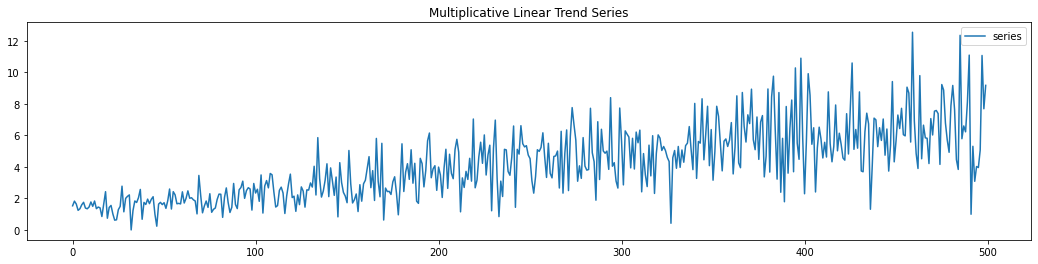

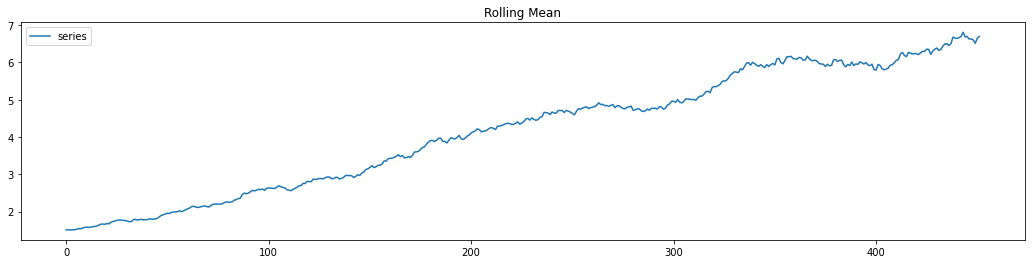

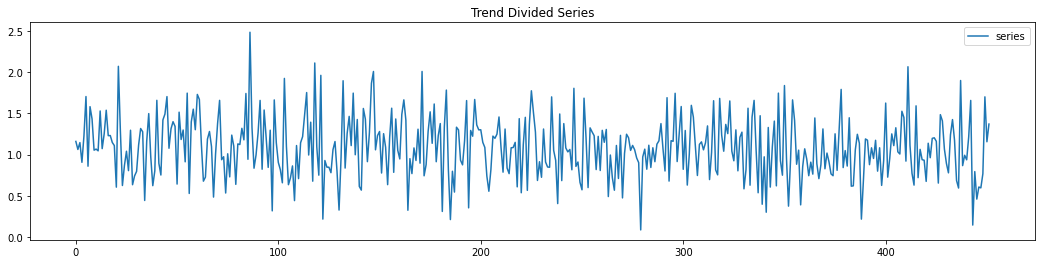

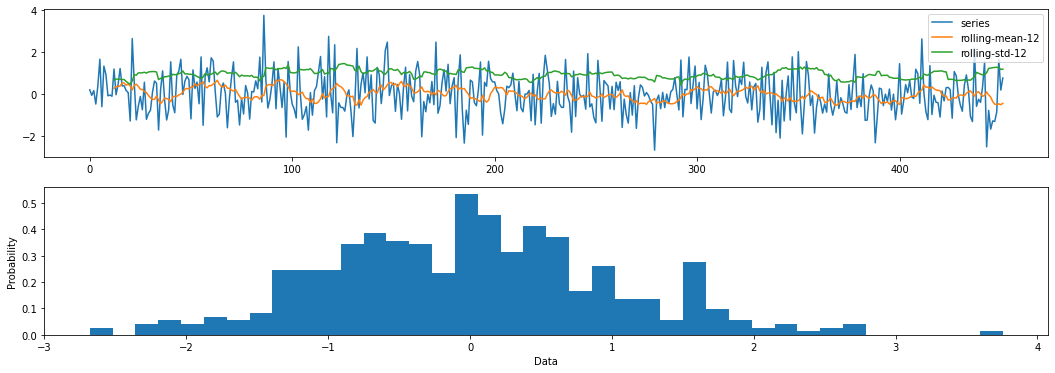

Average Mean -0.0000
Average Variance 1.0000

Third 1 Mean 0.1498, Std 1.0720
Third 1 Mean -0.0419 (-127.96% change), Std 0.9441 (-11.93% change)
Third 2 Mean -0.1143 (-176.29% change), Std 0.9651 (-9.97% change)

Results of Dickey-Fuller Test:
Test Statistic                 -22.519964
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


In [38]:
# display the initial series
display_series(multiplicative_linear_trend_series, title="Multiplicative Linear Trend Series")
window = 48
# remove the trend
trend = get_rolling(multiplicative_linear_trend_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = multiplicative_linear_trend_series[window:] / trend[:,1]
display_series(detrended_series, title="Trend Divided Series")
# remove the rolling variance
detrended_series = (detrended_series - np.mean(detrended_series))/np.std(detrended_series)
# display_series(detrended_series, title="Standardized Detrended Series")
# trend_variance = get_rolling(detrended_series, window, np.std)
# display_series(trend_variance[:,1], title="Variance Trend")
# devarianced_series = detrended_series[window:] / trend_variance[:,1]
# display the final series
plot_series(detrended_series)

### Removing the Weighted Rolling Mean

Here we will do the same thing as before, and it should work for the same reason. The only difference is that here we will be using a weighting when taking the mean value that prioritizes the most recent points in time over the less recent.

Remember that in this rolling mean methodology we are looking at the last N days, the reason we look backwards is so that this technique could actually be applied to forecasting going forward, we don't rely on any future knowledge. This means we skew the data less, but we still have some skew since we do not account for the entire trend.

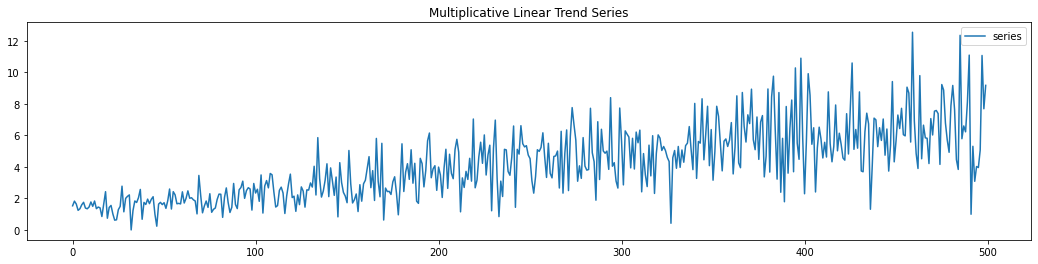

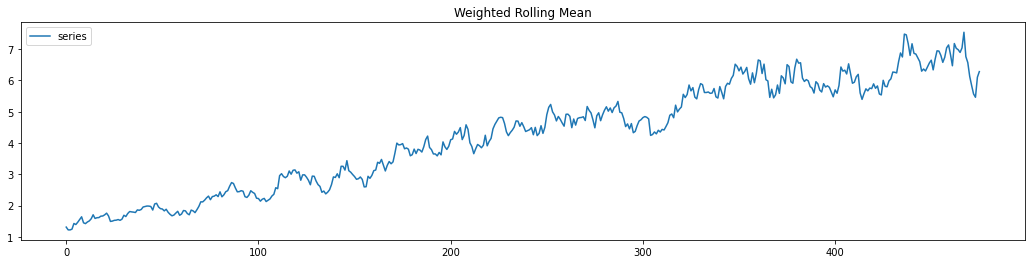

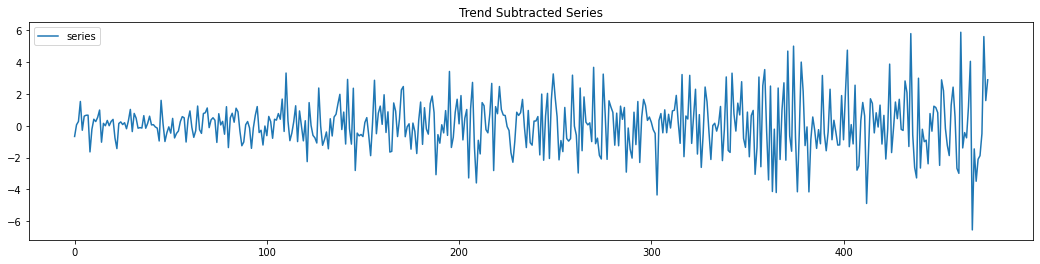

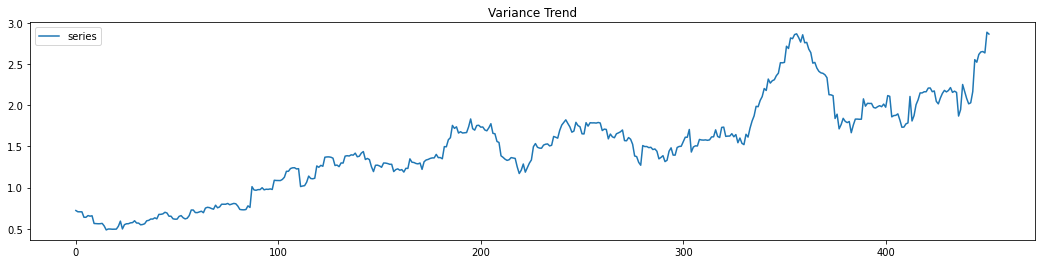

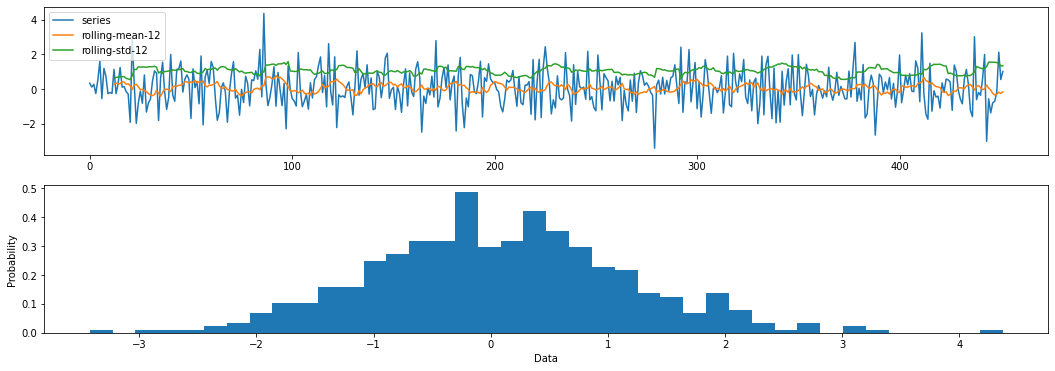

Average Mean 0.0717
Average Variance 1.0953

Third 1 Mean 0.1347, Std 1.1031
Third 1 Mean 0.0579 (-57.01% change), Std 1.0640 (-3.55% change)
Third 2 Mean 0.0132 (-90.23% change), Std 1.1184 (1.39% change)

Results of Dickey-Fuller Test:
Test Statistic                -9.733297e+00
p-value                        8.885739e-17
#Lags Used                     7.000000e+00
Number of Observations Used    4.440000e+02
Critical Value (1%)           -3.445164e+00
Critical Value (5%)           -2.868072e+00
Critical Value (10%)          -2.570249e+00
dtype: float64


In [19]:
# display the initial series
display_series(multiplicative_linear_trend_series, title="Multiplicative Linear Trend Series")
window = 24
# remove the trend
trend = get_rolling_averaged(multiplicative_linear_trend_series, window)
display_series(trend[:,1], title="Weighted Rolling Mean")
detrended_series = multiplicative_linear_trend_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# remove the rolling variance
trend_variance = get_rolling(detrended_series, window, np.std)
display_series(trend_variance[:,1], title="Variance Trend")
devarianced_series = detrended_series[window:] / trend_variance[:,1]
# display the final series
plot_series(devarianced_series)

### Differencing the Series

The technique of differencing is pretty simple, rather than looking at a time series as a range of values, differencing is just looking at the time series as the change from one time step to another. Say we had the series 1, 3, 5, 1 well the differenced series would be 2, 2, -4.

Differencing works becuase while a time series may have general overall trends and changes, the day to day volatility will tend to be normally distributed. If we model that day to day volatility instead we will have nicer data. The other advantage is that it makes a little more sense to model how a time series increases or decreases in response to different signal, rather than just predicting absolute values of the time series.

In a multilicative series we still have the issue of having increasing variance over time. This can again be acccounted for by dividng by the rolling variance.

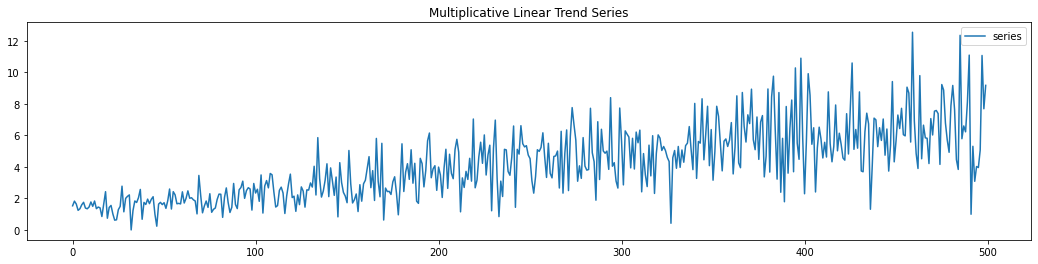

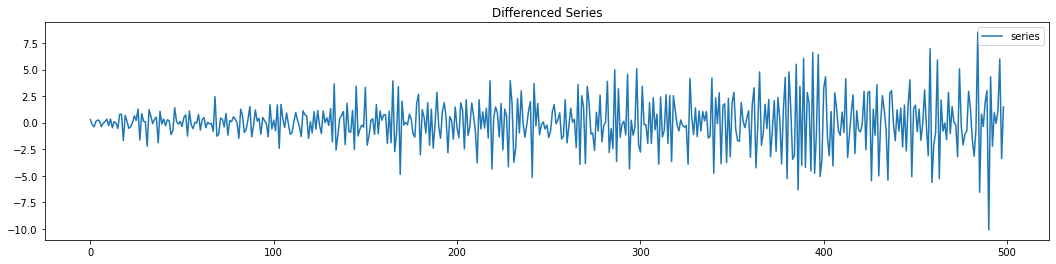

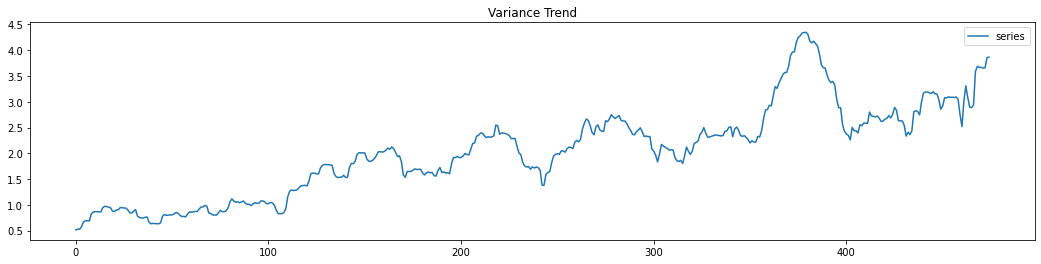

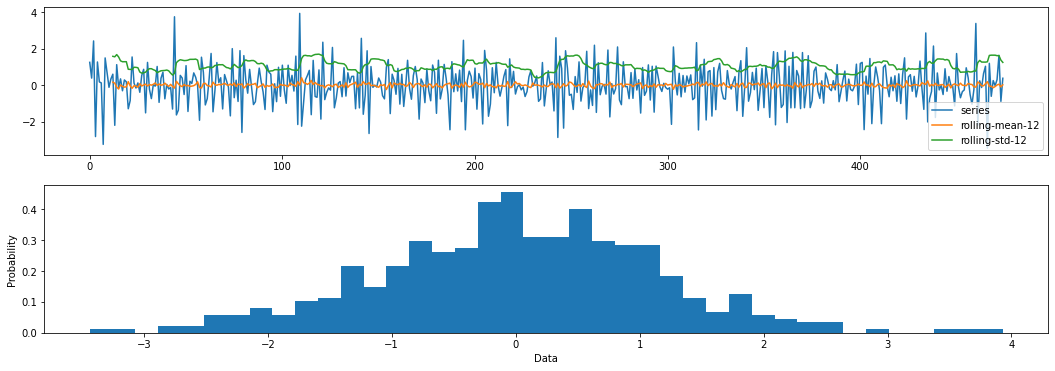

Average Mean 0.0134
Average Variance 1.1152

Third 1 Mean 0.0262, Std 1.1675
Third 1 Mean 0.0125 (-52.11% change), Std 1.0524 (-9.85% change)
Third 2 Mean -0.0009 (-103.34% change), Std 1.1257 (-3.58% change)

Results of Dickey-Fuller Test:
Test Statistic                -9.543340e+00
p-value                        2.689858e-16
#Lags Used                     1.400000e+01
Number of Observations Used    4.600000e+02
Critical Value (1%)           -3.444646e+00
Critical Value (5%)           -2.867844e+00
Critical Value (10%)          -2.570128e+00
dtype: float64


In [20]:
# display the inital series
display_series(multiplicative_linear_trend_series, title="Multiplicative Linear Trend Series")
# difference the series
differenced_series = np.diff(multiplicative_linear_trend_series, 1)
display_series(differenced_series, title="Differenced Series")
# remove the rolling variance
trend_variance = get_rolling(differenced_series, window, np.std)
display_series(trend_variance[:,1], title="Variance Trend")
devarianced_series = differenced_series[window:] / trend_variance[:,1]
# display the final series
plot_series(devarianced_series)

### Box-Cox Power Transformer

Another technique we can use on multiplicative data to make it stationary is a power transform. The Box Cox transform is a method of applying a logarithmic transform. This means that as a value gets higher and higher it has less and less effect. This can remove the multiplicative impact of the time series, allowing us to difference it like an addative time series.

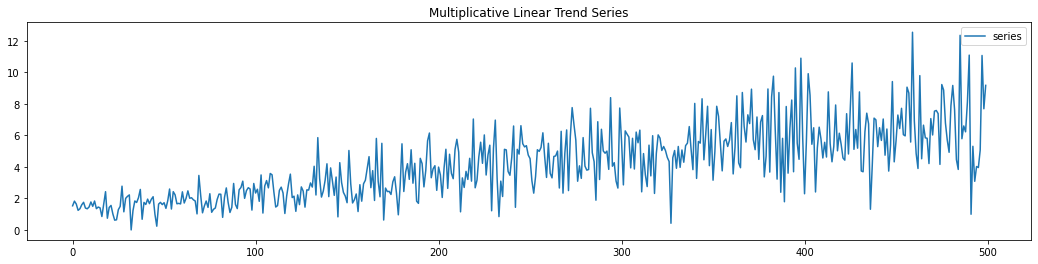

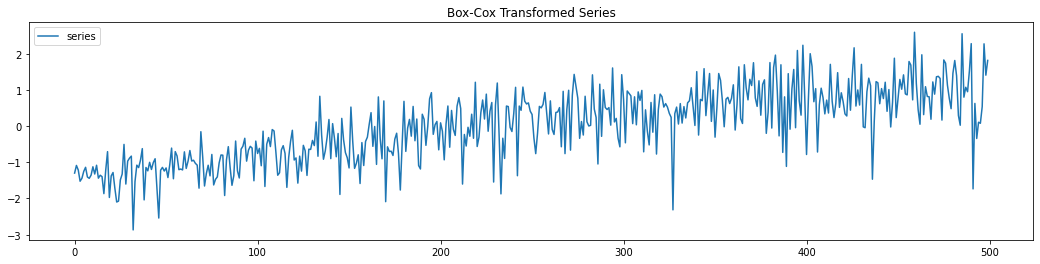

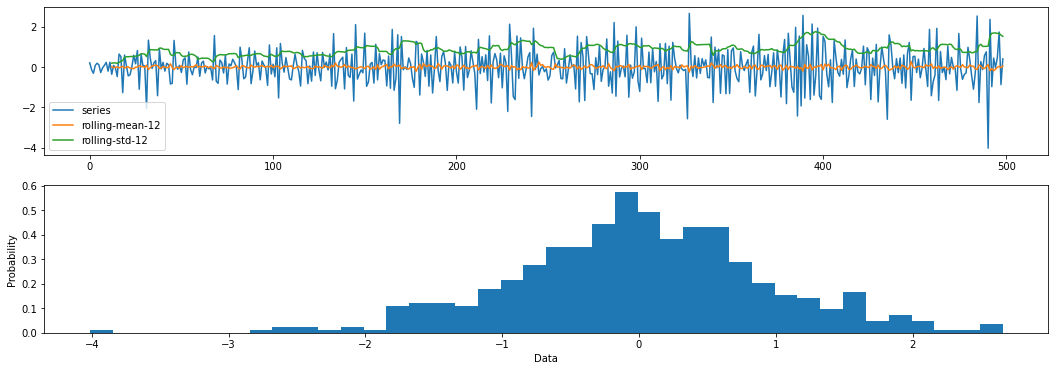

Average Mean 0.0062
Average Variance 0.9308

Third 1 Mean 0.0127, Std 0.6788
Third 1 Mean -0.0044 (-134.36% change), Std 0.9836 (44.89% change)
Third 2 Mean 0.0080 (-37.13% change), Std 1.0840 (59.69% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.047463e+01
p-value                        1.258355e-18
#Lags Used                     1.400000e+01
Number of Observations Used    4.840000e+02
Critical Value (1%)           -3.443933e+00
Critical Value (5%)           -2.867530e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


In [21]:
# display the inital series
display_series(multiplicative_linear_trend_series, title="Multiplicative Linear Trend Series")
# transform the series
transformed_series = PowerTransformer(method='box-cox', standardize=True).fit_transform(multiplicative_linear_trend_series.reshape(-1,1) + 1).flatten()
display_series(transformed_series, title="Box-Cox Transformed Series")
# difference the series
differenced_series = np.diff(transformed_series, 1)
# display the final series
plot_series(differenced_series)

### Yeo-Johnson Power Transformer

The Yeo-Johnson Transform is another power transform that evolved from the Box-Cox Transform.

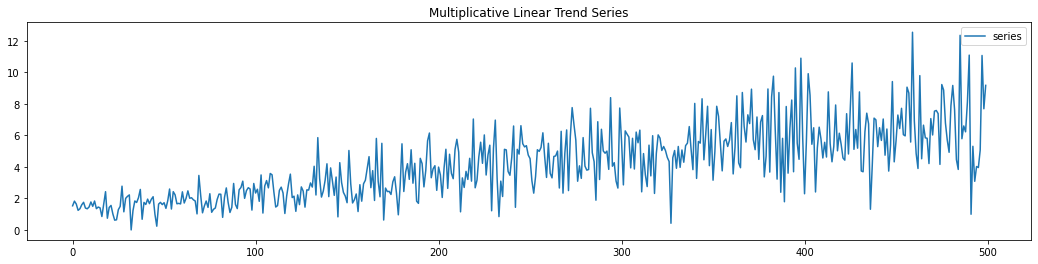

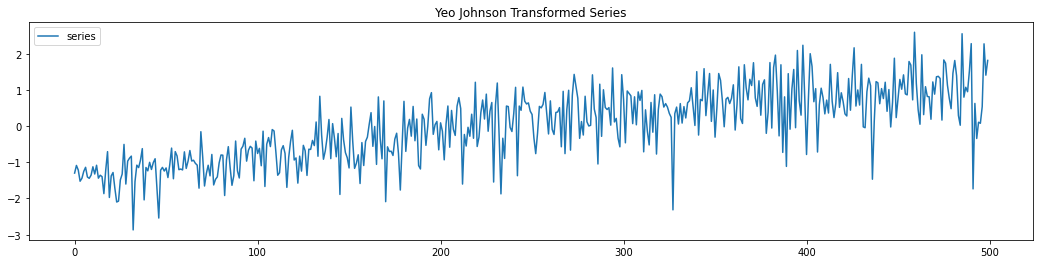

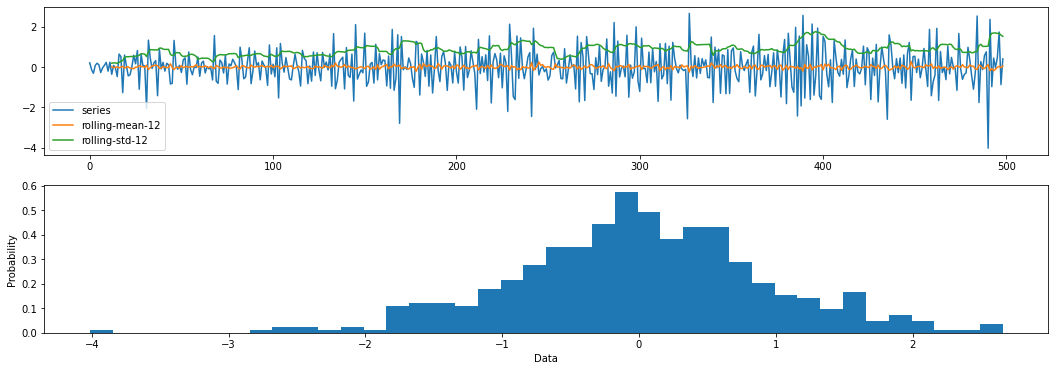

Average Mean 0.0062
Average Variance 0.9308

Third 1 Mean 0.0127, Std 0.6788
Third 1 Mean -0.0044 (-134.36% change), Std 0.9836 (44.89% change)
Third 2 Mean 0.0080 (-37.13% change), Std 1.0840 (59.69% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.047463e+01
p-value                        1.258355e-18
#Lags Used                     1.400000e+01
Number of Observations Used    4.840000e+02
Critical Value (1%)           -3.443933e+00
Critical Value (5%)           -2.867530e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


In [22]:
# display the inital series
display_series(multiplicative_linear_trend_series, title="Multiplicative Linear Trend Series")
# transform the series
transformed_series = PowerTransformer(standardize=True).fit_transform(multiplicative_linear_trend_series.reshape(-1,1)).flatten()
display_series(transformed_series, title="Yeo Johnson Transformed Series")
# difference the series
differenced_series = np.diff(transformed_series, 1)
# display the final series
plot_series(differenced_series)

### Log Transformer

Another technique we can use on multiplicative data to make it stationary is a power transform. The Yeo-Johnson transform is a method of applying a logarithmic transform to the series so that the growth is not being multiplied, leading to increasing variance over time.

MORE DETAIL

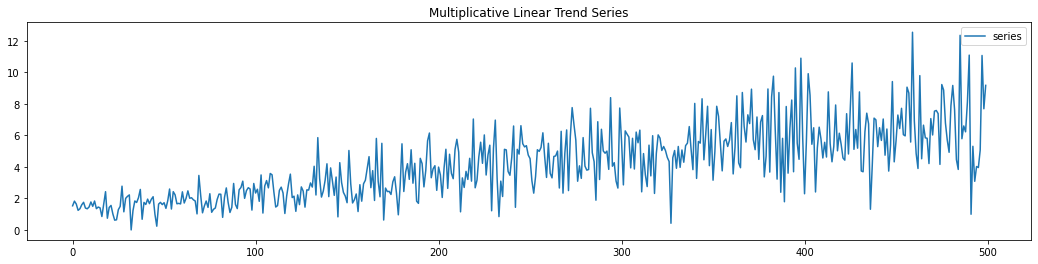

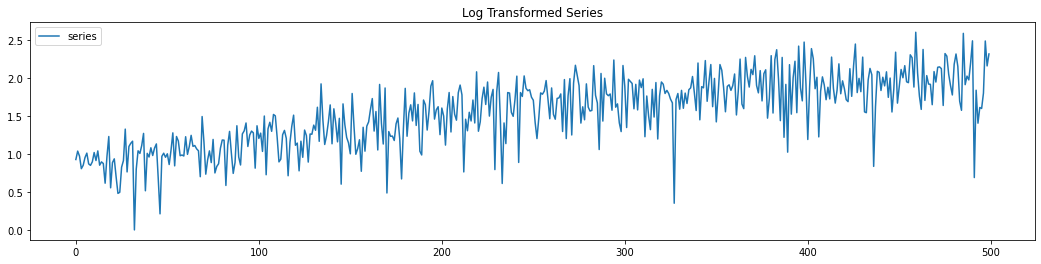

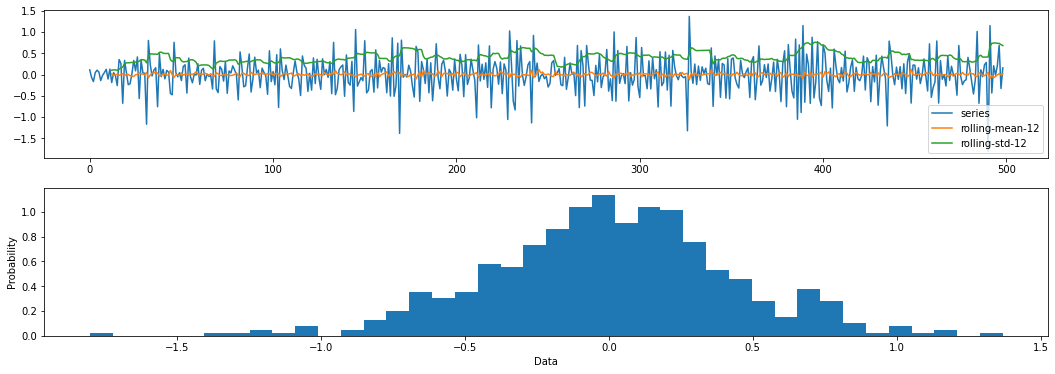

Average Mean 0.0028
Average Variance 0.4261

Third 1 Mean 0.0060, Std 0.3473
Third 1 Mean -0.0019 (-131.76% change), Std 0.4591 (32.22% change)
Third 2 Mean 0.0034 (-43.58% change), Std 0.4627 (33.25% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.033470e+01
p-value                        2.783442e-18
#Lags Used                     1.400000e+01
Number of Observations Used    4.840000e+02
Critical Value (1%)           -3.443933e+00
Critical Value (5%)           -2.867530e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


In [23]:
# display the inital series
display_series(multiplicative_linear_trend_series, title="Multiplicative Linear Trend Series")
# transform the series
transformed_series = np.log(multiplicative_linear_trend_series + 1)
display_series(transformed_series, title="Log Transformed Series")
# difference the series
differenced_series = np.diff(transformed_series, 1)
# display the final series
plot_series(differenced_series)

### Log10 Transformer

Another technique we can use on multiplicative data to make it stationary is a power transform. The Yeo-Johnson transform is a method of applying a logarithmic transform to the series so that the growth is not being multiplied, leading to increasing variance over time.

MORE DETAIL

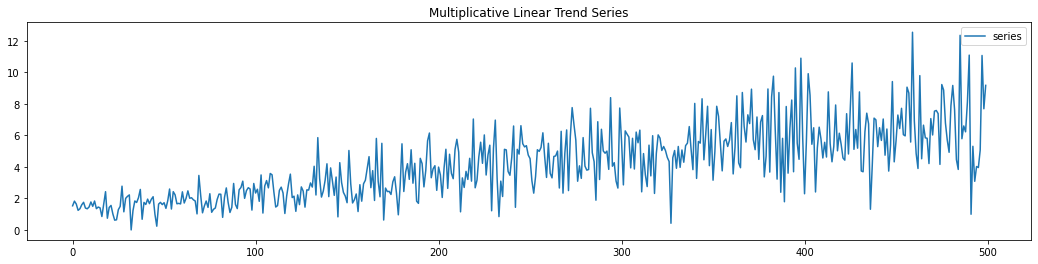

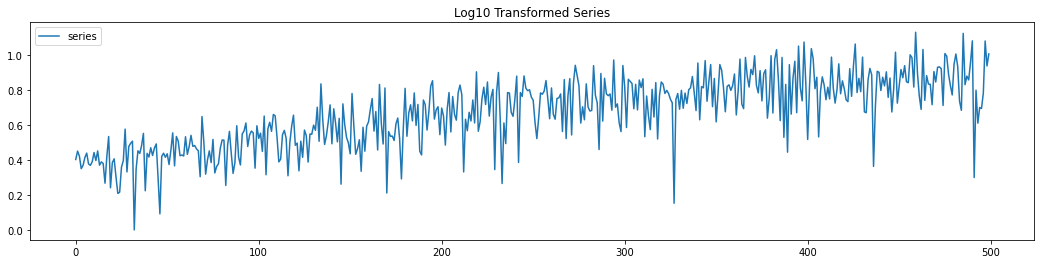

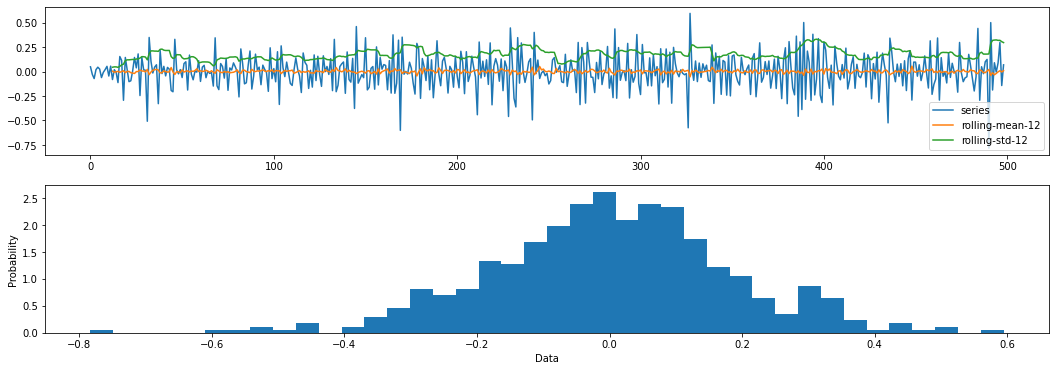

Average Mean 0.0012
Average Variance 0.1850

Third 1 Mean 0.0026, Std 0.1508
Third 1 Mean -0.0008 (-131.76% change), Std 0.1994 (32.22% change)
Third 2 Mean 0.0015 (-43.58% change), Std 0.2009 (33.25% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.033470e+01
p-value                        2.783442e-18
#Lags Used                     1.400000e+01
Number of Observations Used    4.840000e+02
Critical Value (1%)           -3.443933e+00
Critical Value (5%)           -2.867530e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


In [24]:
# display the inital series
display_series(multiplicative_linear_trend_series, title="Multiplicative Linear Trend Series")
# transform the series
transformed_series = np.log10(multiplicative_linear_trend_series + 1)
display_series(transformed_series, title="Log10 Transformed Series")
# difference the series
differenced_series = np.diff(transformed_series, 1)
# display the final series
plot_series(differenced_series)

# Seasonal Time Series

## Additive

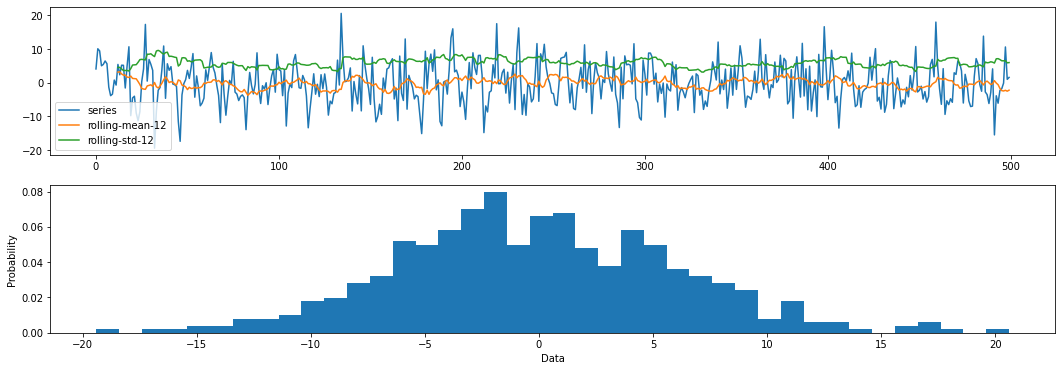

Average Mean -0.1133
Average Variance 6.1598

Third 1 Mean -0.4431, Std 6.1919
Third 1 Mean 0.2556 (-157.69% change), Std 6.4148 (3.60% change)
Third 2 Mean -0.1696 (-61.72% change), Std 5.8755 (-5.11% change)

Results of Dickey-Fuller Test:
Test Statistic                -6.326995e+00
p-value                        2.969565e-08
#Lags Used                     1.800000e+01
Number of Observations Used    4.810000e+02
Critical Value (1%)           -3.444018e+00
Critical Value (5%)           -2.867568e+00
Critical Value (10%)          -2.569980e+00
dtype: float64


In [25]:
additive_seasonal_series = ADDITIVE_NOISE + ADDITIVE_SEASONALITY
plot_series(additive_seasonal_series)

### Remove Seasonal Mean

Since we know the period in which the series is seasonal, we can take the mean value for each seasonal period and then subtract that from the series. This should hopefully isolate the noise from the seasonal trend that is found in the series. This will make the time series stationary, so long as we do not have a trend in the series, otherwise we would need more steps here.

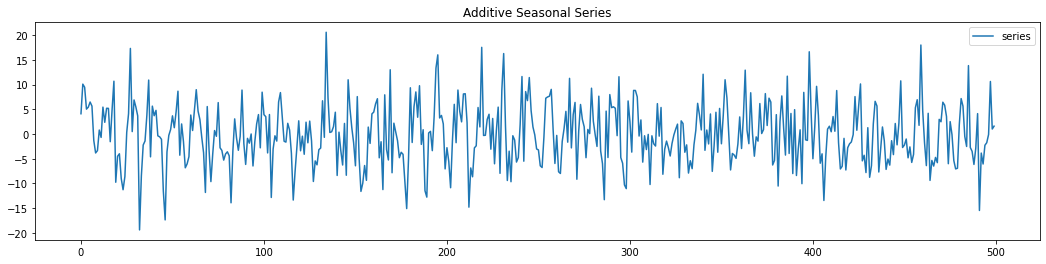

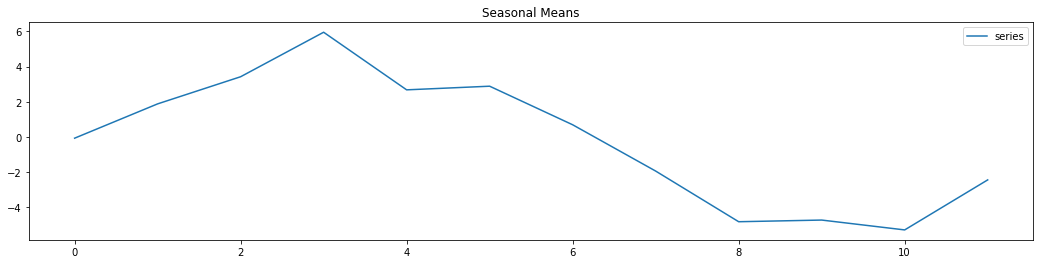

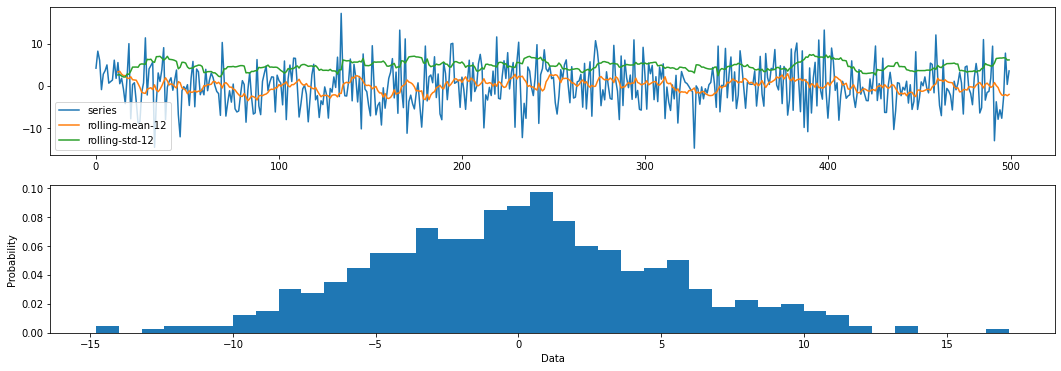

Average Mean 0.0000
Average Variance 5.0538

Third 1 Mean -0.3411, Std 4.9076
Third 1 Mean 0.3466 (-201.60% change), Std 5.2433 (6.84% change)
Third 2 Mean -0.0287 (-91.60% change), Std 5.0043 (1.97% change)

Results of Dickey-Fuller Test:
Test Statistic                 -23.304718
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


In [26]:
# display the original series
display_series(additive_seasonal_series, title="Additive Seasonal Series")
# get the seasonal means
seasonal_mean = get_periodic(additive_seasonal_series, SEASONALITY_PERIOD, np.mean)
display_series(seasonal_mean[:SEASONALITY_PERIOD], title="Seasonal Means")
deseasonalized_series = additive_seasonal_series - seasonal_mean
# display the final series
plot_series(deseasonalized_series)

### Differencing Series

The series may have seasonal means, but if we look at the difference between results this should model white noise. The reason for this is that so long as the seasonal component is negligable on a day to day level, the main thing we will be isolating is the noise.

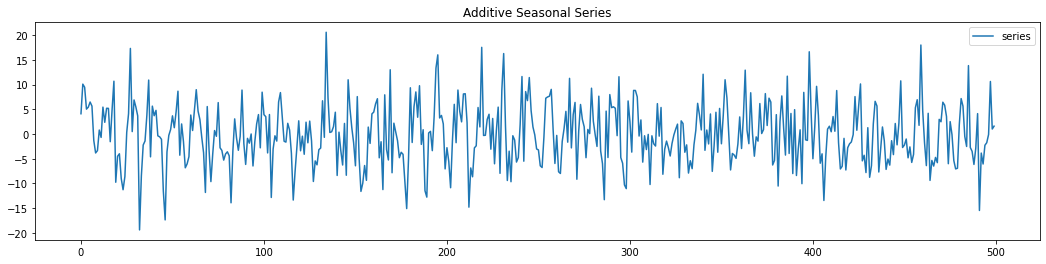

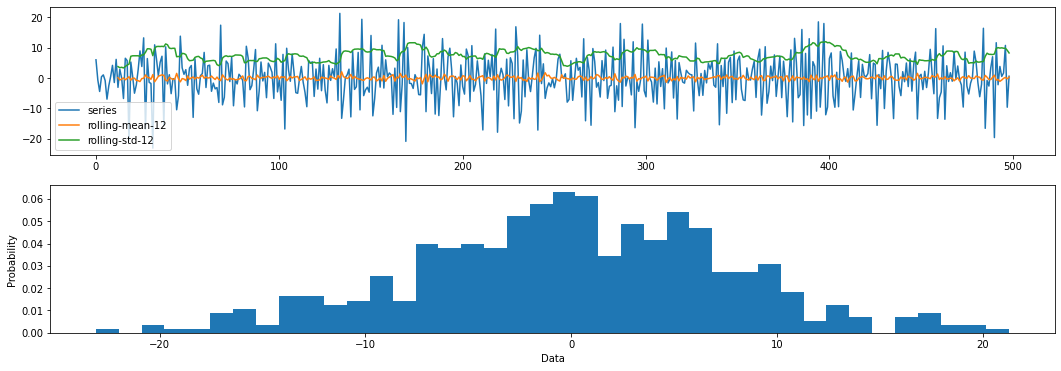

Average Mean -0.0050
Average Variance 7.6212

Third 1 Mean 0.0230, Std 7.2928
Third 1 Mean -0.0954 (-514.05% change), Std 7.9201 (8.60% change)
Third 2 Mean 0.0537 (133.18% change), Std 7.6596 (5.03% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.235420e+01
p-value                        5.735057e-23
#Lags Used                     1.300000e+01
Number of Observations Used    4.850000e+02
Critical Value (1%)           -3.443905e+00
Critical Value (5%)           -2.867518e+00
Critical Value (10%)          -2.569954e+00
dtype: float64


In [27]:
# display the original series
display_series(additive_seasonal_series, title="Additive Seasonal Series")
# difference the series
differenced_series = np.diff(additive_seasonal_series, 1)
# display the final series
plot_series(differenced_series)

## Multiplicative

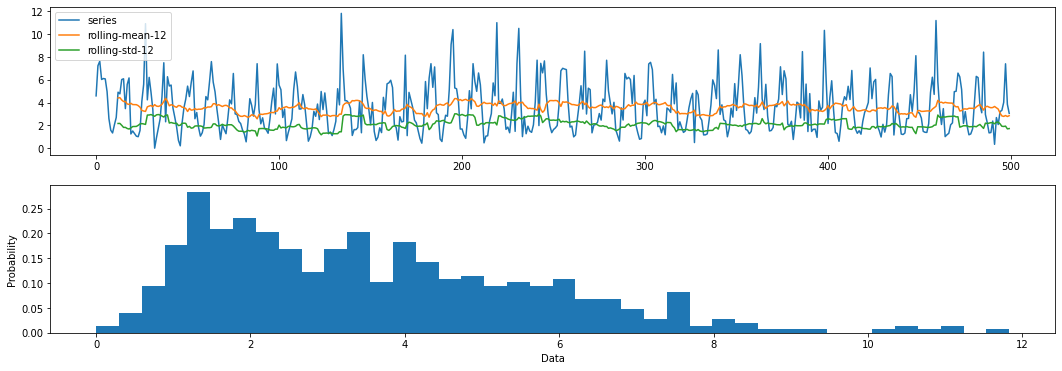

Average Mean 3.5780
Average Variance 2.1632

Third 1 Mean 3.5267, Std 2.0986
Third 1 Mean 3.6883 (4.58% change), Std 2.2761 (8.46% change)
Third 2 Mean 3.5206 (-0.17% change), Std 2.1189 (0.97% change)

Results of Dickey-Fuller Test:
Test Statistic                -5.674780e+00
p-value                        8.755567e-07
#Lags Used                     1.800000e+01
Number of Observations Used    4.810000e+02
Critical Value (1%)           -3.444018e+00
Critical Value (5%)           -2.867568e+00
Critical Value (10%)          -2.569980e+00
dtype: float64


In [28]:
multiplicative_seasonal_series = MULTIPLICATIVE_NOISE * MULTIPLICATIVE_SEASONALITY
plot_series(multiplicative_seasonal_series)

### Remove Seasonal Mean

Since we know the period in which the series is seasonal, we can take the mean value for each seasonal period and then divide that from the series. This should hopefully isolate the noise from the seasonal trend that is found in the series. For the multiplicative series this is a little less effective as the seasonal component gets multiplied.

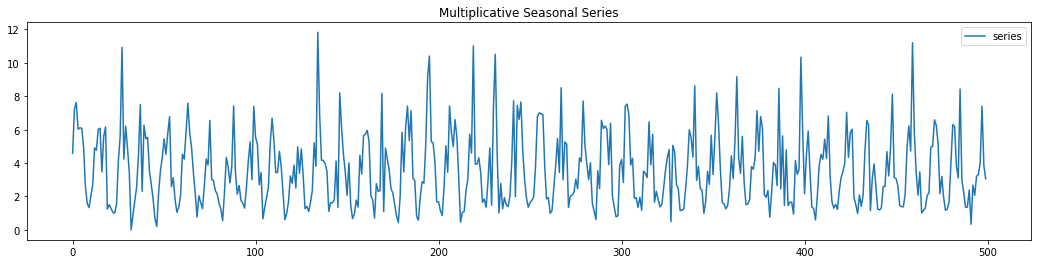

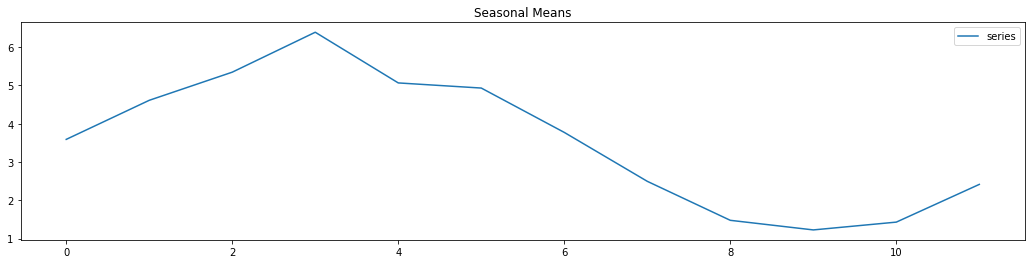

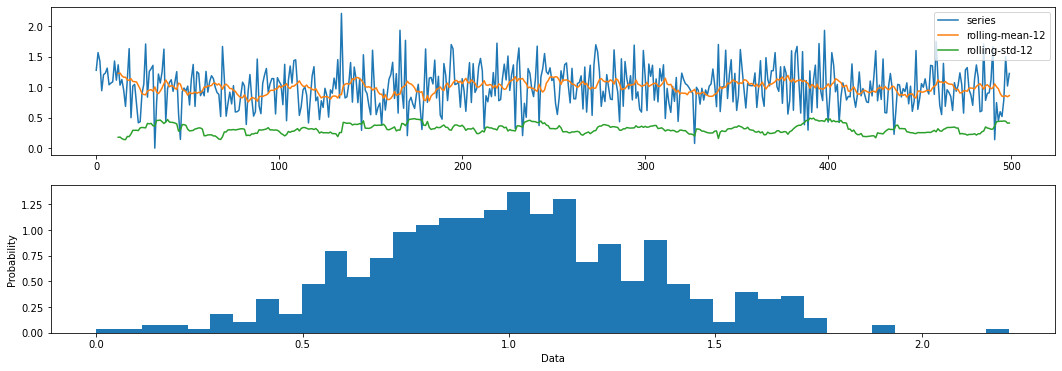

Average Mean 1.0000
Average Variance 0.3392

Third 1 Mean 0.9767, Std 0.3304
Third 1 Mean 1.0225 (4.69% change), Std 0.3504 (6.03% change)
Third 2 Mean 0.9994 (2.32% change), Std 0.3365 (1.83% change)

Results of Dickey-Fuller Test:
Test Statistic                 -23.365823
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


In [39]:
# display the original series
display_series(multiplicative_seasonal_series, title="Multiplicative Seasonal Series")
# get the seasonal means
seasonal_mean = get_periodic(multiplicative_seasonal_series, SEASONALITY_PERIOD, np.mean)
display_series(seasonal_mean[:SEASONALITY_PERIOD], title="Seasonal Means")
deseasonalized_series = multiplicative_seasonal_series / seasonal_mean
# display the final series
plot_series(deseasonalized_series)

### Differencing Series

The series may have seasonal means, but if we look at the difference between results this should model white noise. However because this is a multiplicative series we see this is not hte case. The issiue with this series is that the peaks in seasonality, even when differenced, have a much higher volatility than we would like, creating larger spikes than ideal in the series. 

Simply differencing this series is not the ideal approach becuase variance is now correlated with the seasonality rather than the trend in time.

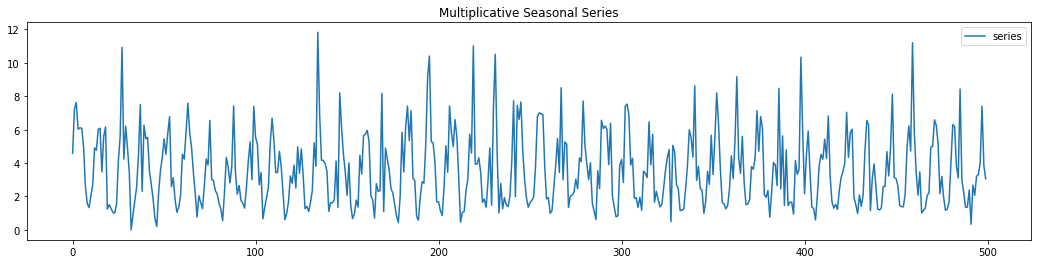

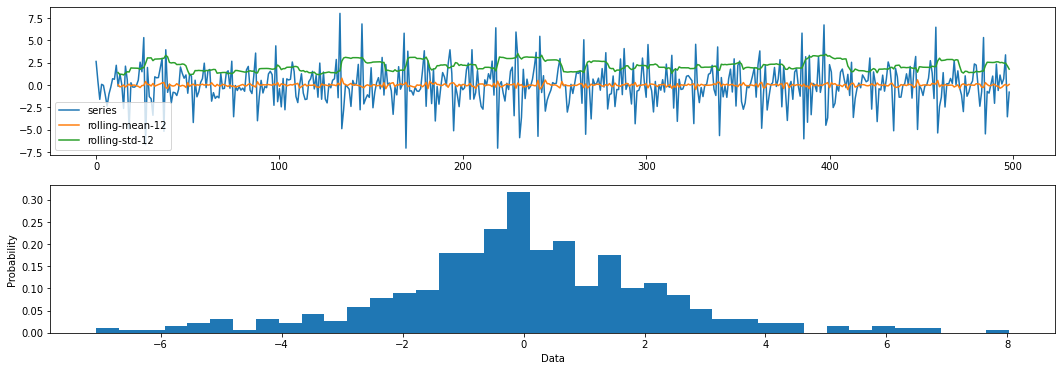

Average Mean -0.0031
Average Variance 2.2190

Third 1 Mean -0.0110, Std 2.0122
Third 1 Mean -0.0096 (-12.32% change), Std 2.3696 (17.76% change)
Third 2 Mean 0.0162 (-247.16% change), Std 2.2655 (12.59% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.304880e+01
p-value                        2.163605e-24
#Lags Used                     1.300000e+01
Number of Observations Used    4.850000e+02
Critical Value (1%)           -3.443905e+00
Critical Value (5%)           -2.867518e+00
Critical Value (10%)          -2.569954e+00
dtype: float64


In [40]:
# display the original series
display_series(multiplicative_seasonal_series, title="Multiplicative Seasonal Series")
# difference the series
differenced_series = np.diff(multiplicative_seasonal_series, 1)
# display the final series
plot_series(differenced_series)

### Yeo-Johnson Power Transformer

Another technique we can use on multiplicative data to make it stationary is a power transform. The Yeo-Johnson transform is a method of applying a logarithmic transform to the series so that the growth is not being multiplied, leading to increasing variance over time.

The issue with this model (when there is no trend) is that by bringing our values together we actually create two humps in the data. This is caused by the lower values being scaled up to allow them to be transformed

MORE DETAIL

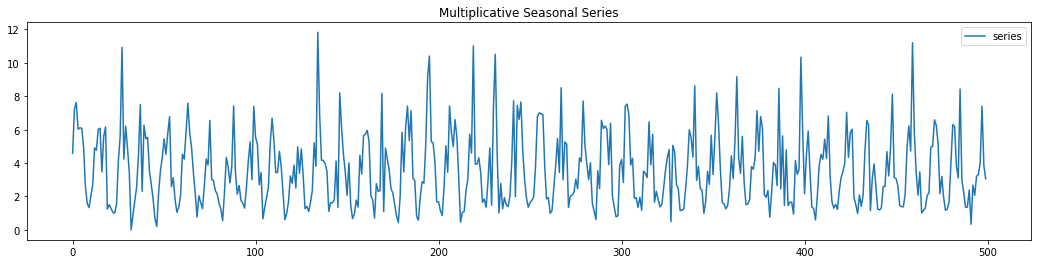

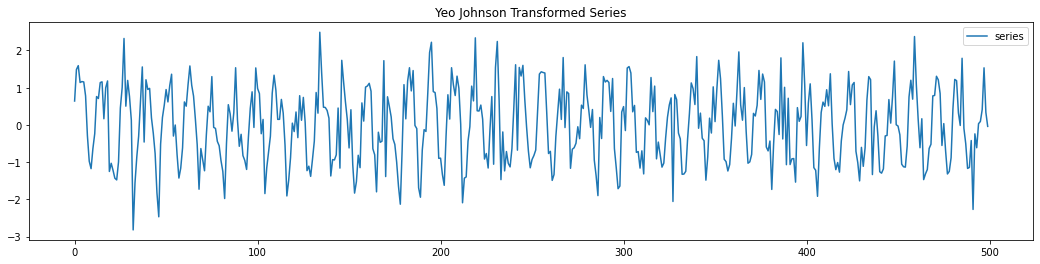

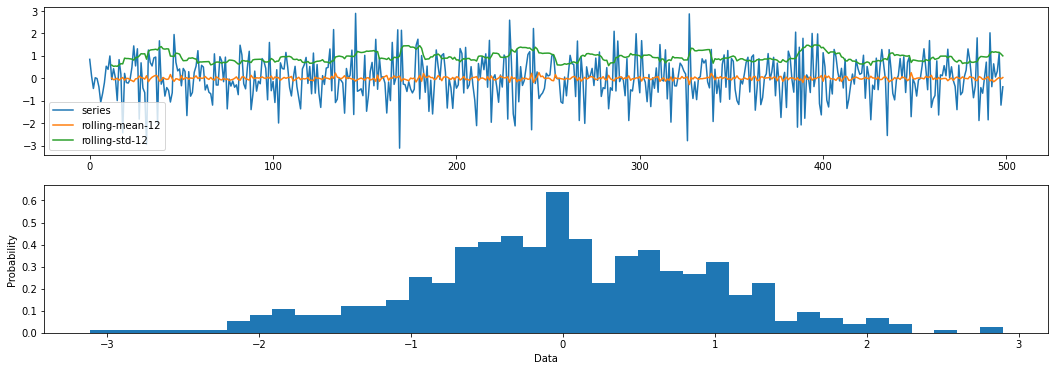

Average Mean -0.0014
Average Variance 0.9643

Third 1 Mean -0.0050, Std 0.9051
Third 1 Mean -0.0068 (34.90% change), Std 1.0375 (14.62% change)
Third 2 Mean 0.0100 (-298.64% change), Std 0.9479 (4.72% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.515946e+01
p-value                        6.622293e-28
#Lags Used                     1.200000e+01
Number of Observations Used    4.860000e+02
Critical Value (1%)           -3.443877e+00
Critical Value (5%)           -2.867505e+00
Critical Value (10%)          -2.569947e+00
dtype: float64


In [31]:
# display the inital series
display_series(multiplicative_seasonal_series, title="Multiplicative Seasonal Series")
# transform the series
transformed_series = PowerTransformer(standardize=True).fit_transform(multiplicative_seasonal_series.reshape(-1,1)).flatten()
display_series(transformed_series, title="Yeo Johnson Transformed Series")
# difference the series
differenced_series = np.diff(transformed_series, 1)
# display the final series
plot_series(differenced_series)

# Linear Trend Seasonal Time Series
## Additive

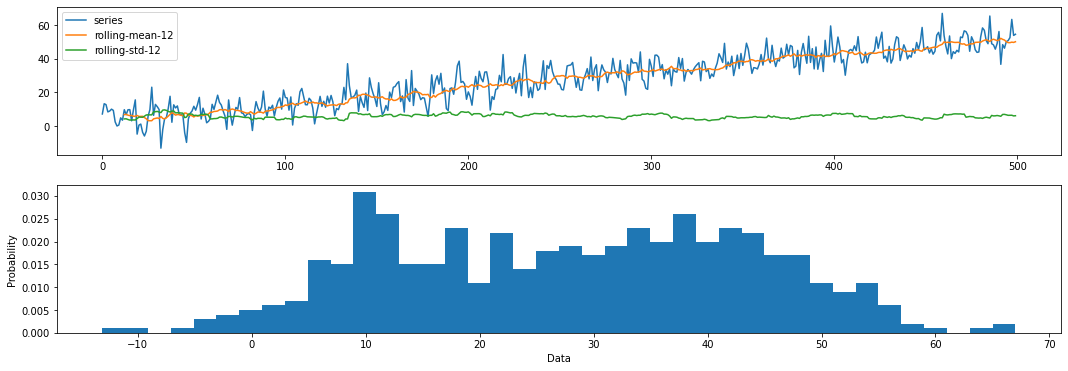

Average Mean 27.9367
Average Variance 15.6567

Third 1 Mean 10.9069, Std 7.3630
Third 1 Mean 28.2056 (158.60% change), Std 7.8981 (7.27% change)
Third 2 Mean 44.3804 (306.90% change), Std 7.2753 (-1.19% change)

Results of Dickey-Fuller Test:
Test Statistic                  -0.264063
p-value                          0.930442
#Lags Used                      13.000000
Number of Observations Used    486.000000
Critical Value (1%)             -3.443877
Critical Value (5%)             -2.867505
Critical Value (10%)            -2.569947
dtype: float64


In [32]:
linear_trend_seasonal_additive_series = ADDITIVE_NOISE + ADDITIVE_SEASONALITY + ADDITIVE_LINEAR_TREND
plot_series(linear_trend_seasonal_additive_series)

### Remove rolling mean and seasonal mean

We can remove the rolling mean by taking the mean of a window larger than the seasonal period. We can then remove the seasonal mean from the isolated series and we should get the isolated white noise.

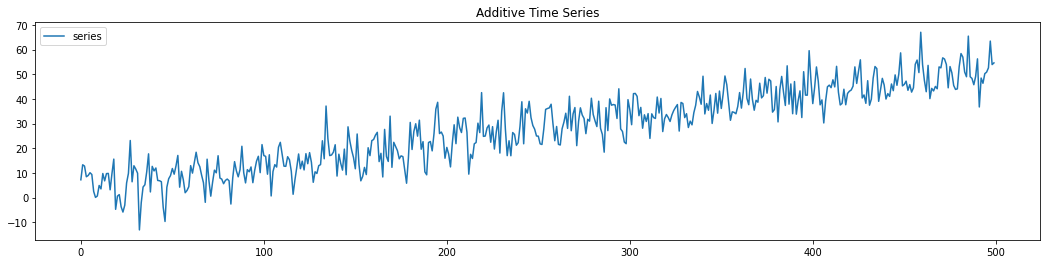

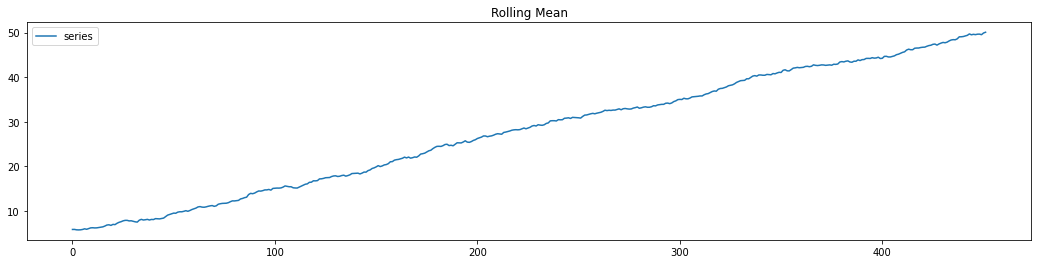

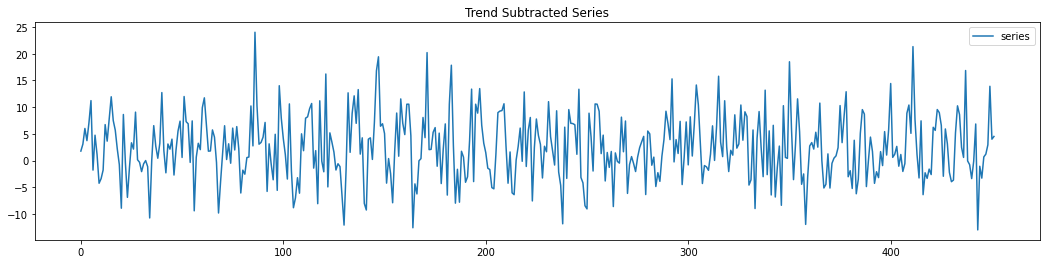

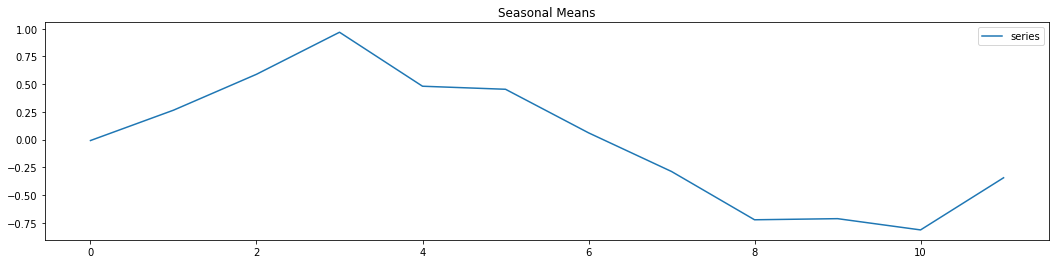

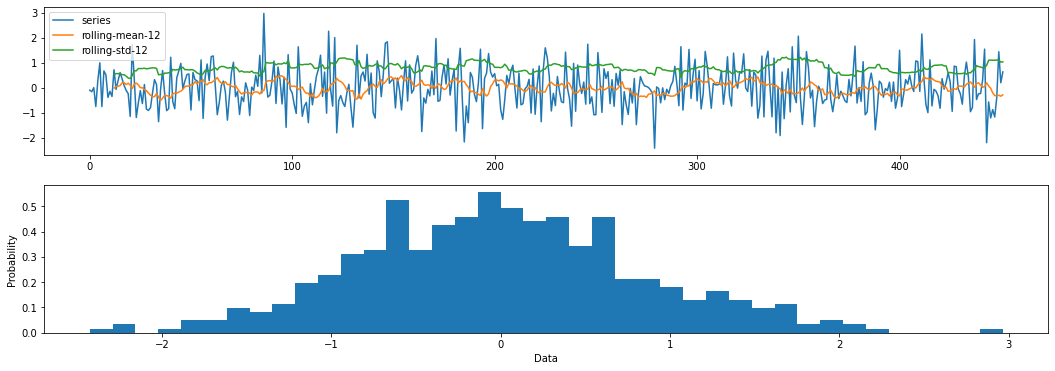

Average Mean -0.0000
Average Variance 0.8329

Third 1 Mean 0.0212, Std 0.8344
Third 1 Mean -0.0088 (-141.48% change), Std 0.8251 (-1.11% change)
Third 2 Mean -0.0178 (-184.19% change), Std 0.8424 (0.96% change)

Results of Dickey-Fuller Test:
Test Statistic                 -22.814702
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


In [33]:
# display the initial series
display_series(linear_trend_seasonal_additive_series, title="Additive Time Series")
# remove the rolling mean
window = 48
trend = get_rolling(linear_trend_seasonal_additive_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = linear_trend_seasonal_additive_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# remove the seasonal mean
detrended_series = (detrended_series - detrended_series.mean()) / detrended_series.std()
seasonal_mean = get_periodic(detrended_series, SEASONALITY_PERIOD, np.mean)
display_series(seasonal_mean[:SEASONALITY_PERIOD], title="Seasonal Means")
deseasonalized_series = detrended_series - seasonal_mean
# display the final series
plot_series(deseasonalized_series)

### Difference the series

INFO

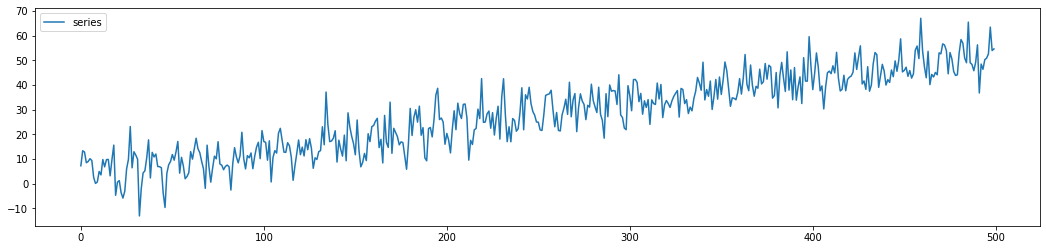

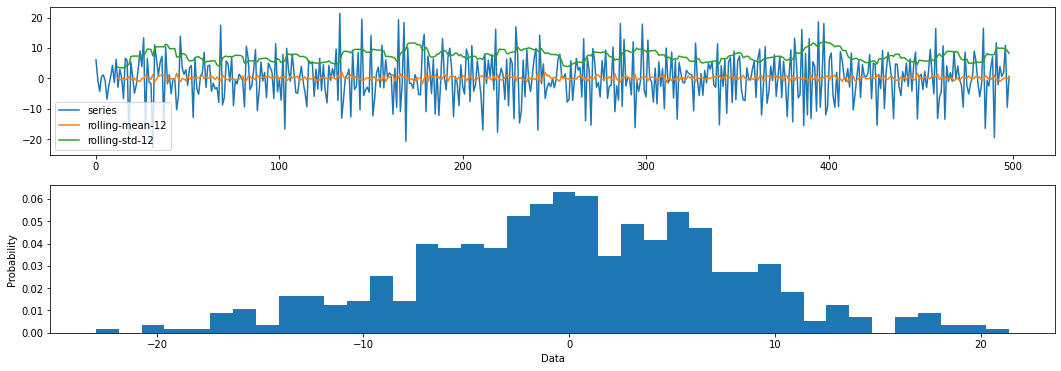

Average Mean 0.0950
Average Variance 7.6212

Third 1 Mean 0.1230, Std 7.2928
Third 1 Mean 0.0046 (-96.25% change), Std 7.9201 (8.60% change)
Third 2 Mean 0.1537 (24.94% change), Std 7.6596 (5.03% change)

Results of Dickey-Fuller Test:
Test Statistic                -1.235420e+01
p-value                        5.735057e-23
#Lags Used                     1.300000e+01
Number of Observations Used    4.850000e+02
Critical Value (1%)           -3.443905e+00
Critical Value (5%)           -2.867518e+00
Critical Value (10%)          -2.569954e+00
dtype: float64


In [34]:
# display the initial series
display_series(linear_trend_seasonal_additive_series)
# difference the series
differenced_series = np.diff(linear_trend_seasonal_additive_series, 1)
# display the end series
plot_series(differenced_series)

# Yeo Johnson Normalization Then Differencing

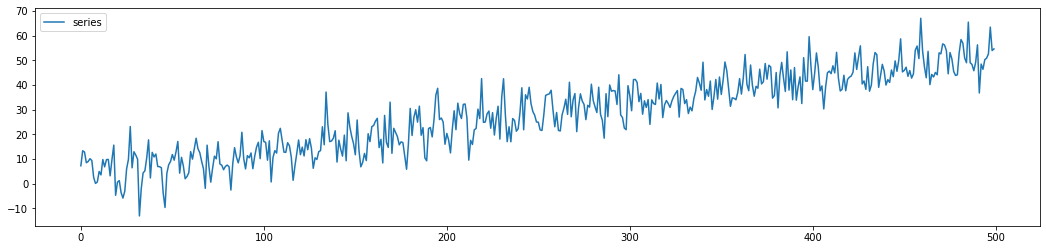

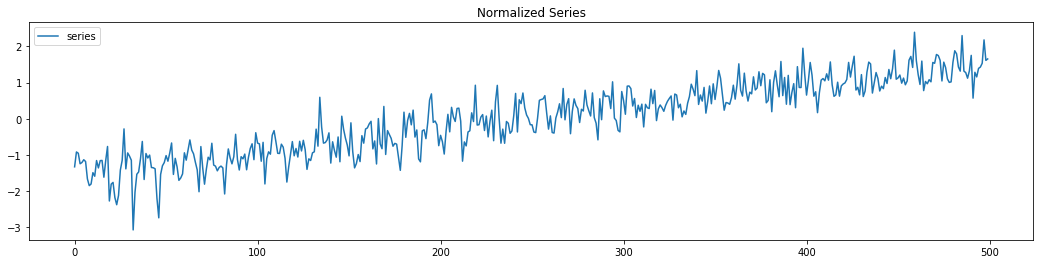

NameError: name 'nomralized_series' is not defined

In [35]:
# display the initial series
display_series(linear_trend_seasonal_additive_series)
# normalize the series
normalized_series = PowerTransformer(standardize=True).fit_transform(linear_trend_seasonal_additive_series.reshape(-1,1)).flatten()
display_series(normalized_series, title="Normalized Series")
# difference the series
differenced_series = np.diff(nomralized_series, 1)
# display the end series
plot_series(differenced_series)

## Multiplicative

In [ ]:
linear_trend_seasonal_multiplicative_series = MULTIPLICATIVE_NOISE * MULTIPLICATIVE_LINEAR_TREND * MULTIPLICATIVE_SEASONALITY
plot_series(linear_trend_seasonal_multiplicative_series)

### Remove rolling mean and seasonal mean

We can remove the rolling mean by taking the mean of a window larger than the seasonal period. We can then remove the seasonal mean from the isolated series and we should get the isolated white noise.

In [ ]:
# display the initial series
display_series(linear_trend_seasonal_multiplicative_series, title="Multiplicative Time Series")
# remove the rolling mean
window = 48
trend = get_rolling(linear_trend_seasonal_multiplicative_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = linear_trend_seasonal_multiplicative_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# remove the seasonal mean
detrended_series = (detrended_series - detrended_series.mean()) / detrended_series.std()
seasonal_mean = get_periodic(detrended_series, SEASONALITY_PERIOD, np.mean)
display_series(seasonal_mean[:SEASONALITY_PERIOD], title="Seasonal Means")
deseasonalized_series = detrended_series - seasonal_mean
# display the final series
plot_series(deseasonalized_series)

### Difference the series

INFO

In [ ]:
# display the initial series
display_series(linear_trend_seasonal_multiplicative_series)
# difference the series
differenced_series = np.diff(linear_trend_seasonal_multiplicative_series, 1)
# display the end series
plot_series(differenced_series)

### Difference the series then removing variance

INFO

In [ ]:
# display the initial series
display_series(linear_trend_seasonal_multiplicative_series)
# difference the series
differenced_series = np.diff(linear_trend_seasonal_multiplicative_series, 1)
display_series(differenced_series, title="Differenced Series")
# remove the rolling variance
window = 24
variance = get_rolling(differenced_series, window, np.std)
devarianced_series = differenced_series[window:] / variance[:,1]
# display the end series
plot_series(devarianced_series)

# Yeo Johnson Normalization Then Differencing

In [ ]:
# display the initial series
display_series(linear_trend_seasonal_multiplicative_series)
# normalize the series
normalized_series = PowerTransformer(standardize=True).fit_transform(linear_trend_seasonal_multiplicative_series.reshape(-1,1)).flatten()
display_series(normalized_series, title="Normalized Series")
# difference the series
differenced_series = np.diff(nomralized_series, 1)
# display the end series
plot_series(differenced_series)

# Exponential Trend Seasonal Time Series
## Additive

In [ ]:
exponential_trend_seasonal_additive_series = ADDITIVE_NOISE + ADDITIVE_SEASONALITY + ADDITIVE_EXPONENTIAL_TREND
plot_series(exponential_trend_seasonal_additive_series)

### Remove rolling mean and seasonal mean

We can remove the rolling mean by taking the mean of a window larger than the seasonal period. We can then remove the seasonal mean from the isolated series and we should get the isolated white noise.

In [ ]:
# display the initial series
display_series(exponential_trend_seasonal_additive_series, title="Additive Time Series")
# remove the rolling mean (this removes the exponential trend)
window = 12
trend = get_rolling(exponential_trend_seasonal_additive_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = exponential_trend_seasonal_additive_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# remove the rolling mean (this removes the exponential trend)
window = 12
trend = get_rolling(detrended_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = detrended_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# remove the seasonal mean
detrended_series = (detrended_series - detrended_series.mean()) / detrended_series.std()
seasonal_mean = get_periodic(detrended_series, SEASONALITY_PERIOD, np.mean)
display_series(seasonal_mean[:SEASONALITY_PERIOD], title="Seasonal Means")
deseasonalized_series = detrended_series - seasonal_mean
# display the final series
plot_series(deseasonalized_series)

### Remove rolling mean and difference the series

We can remove the rolling mean by taking the mean of a window larger than the seasonal period. We can then remove the seasonal mean from the isolated series and we should get the isolated white noise.

In [ ]:
# display the initial series
display_series(exponential_trend_seasonal_additive_series, title="Additive Time Series")
# remove the rolling mean (this removes the exponential trend)
window = 12
trend = get_rolling(exponential_trend_seasonal_additive_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = exponential_trend_seasonal_additive_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# difference the series
differenced_series = np.diff(detrended_series, 1)
# display the final series
plot_series(differenced_series)

### Difference the series

INFO

In [ ]:
# display the initial series
display_series(exponential_trend_seasonal_additive_series, title="Exponential Trend Seasonal Additive Series")
# difference the series
differenced_series = np.diff(exponential_trend_seasonal_additive_series, 1)
display_series(differenced_series, title="Differenced Series")
# remove rolling mean
window = 48
trend = get_rolling(differenced_series, window, np.mean)
detrended_series = differenced_series[window:] - trend[:,1] 
# display the end series
plot_series(detrended_series)

# Yeo Johnson Normalization Then Differencing

In [ ]:
# display the initial series
display_series(exponential_trend_seasonal_additive_series, title="Exponential Trend Seasonal Additive Series")
# normalize the series
normalized_series = PowerTransformer(standardize=True).fit_transform(exponential_trend_seasonal_additive_series.reshape(-1,1)).flatten()
display_series(normalized_series, title="Normalized Series")
# difference the series
differenced_series = np.diff(nomralized_series, 1)
# display the end series
plot_series(differenced_series)

## Multiplicative

In [ ]:
exponential_trend_seasonal_multiplicative_series = MULTIPLICATIVE_NOISE*MULTIPLICATIVE_EXPONENTIAL_TREND*MULTIPLICATIVE_SEASONALITY
plot_series(exponential_trend_seasonal_multiplicative_series)

### Remove rolling mean and seasonal mean

We can remove the rolling mean by taking the mean of a window larger than the seasonal period. We can then remove the seasonal mean from the isolated series and we should get the isolated white noise.

In [ ]:
# display the initial series
display_series(exponential_trend_seasonal_multiplicative_series, title="Multiplicative Time Series")
# remove the rolling mean (this removes the exponential trend)
window = 24
trend = get_rolling(exponential_trend_seasonal_multiplicative_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = exponential_trend_seasonal_multiplicative_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# remove the absolute rolling mean this standardizes the time series
window = 24
trend = get_rolling(np.abs(detrended_series), window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = detrended_series[window:] / trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# remove the seasonal mean
detrended_series = (detrended_series - detrended_series.mean()) - detrended_series.std()
seasonal_mean = get_periodic(detrended_series, SEASONALITY_PERIOD, np.mean)
display_series(seasonal_mean[:SEASONALITY_PERIOD], title="Seasonal Means")
deseasonalized_series = detrended_series - seasonal_mean
# display the final series
plot_series(deseasonalized_series)

### Remove rolling mean and difference the series

We can remove the rolling mean by taking the mean of a window larger than the seasonal period. We can then remove the seasonal mean from the isolated series and we should get the isolated white noise.

In [ ]:
# display the initial series
display_series(exponential_trend_seasonal_multiplicative_series, title="Additive Time Series")
# remove the rolling mean (this removes the exponential trend)
window = 24
trend = get_rolling(exponential_trend_seasonal_multiplicative_series, window, np.mean)
display_series(trend[:,1], title="Rolling Mean")
detrended_series = exponential_trend_seasonal_multiplicative_series[window:] - trend[:,1]
display_series(detrended_series, title="Trend Subtracted Series")
# difference the series
differenced_series = np.diff(detrended_series, 1)
differenced_series = (differenced_series - differenced_series.mean()) / differenced_series.std()
display_series(differenced_series, title="Differenced Series")
# remove the rolling variance
variance = get_rolling(differenced_series, window, np.std)
devarianced_series = differenced_series[window:] / variance[:,1]
# display the final series
plot_series(devarianced_series)

### Difference the series

INFO

In [ ]:
# display the initial series
display_series(exponential_trend_seasonal_additive_series, title="Exponential Trend Seasonal Additive Series")
# difference the series
differenced_series = np.diff(exponential_trend_seasonal_additive_series, 1)
display_series(differenced_series, title="Differenced Series")
# remove rolling mean
window = 48
trend = get_rolling(differenced_series, window, np.mean)
detrended_series = differenced_series[window:] - trend[:,1] 
# display the end series
plot_series(detrended_series)

# Yeo Johnson Normalization Then Differencing

In [ ]:
# display the initial series
display_series(exponential_trend_seasonal_additive_series, title="Exponential Trend Seasonal Additive Series")
# normalize the series
normalized_series = PowerTransformer(standardize=True).fit_transform(exponential_trend_seasonal_additive_series.reshape(-1,1)).flatten()
display_series(normalized_series, title="Normalized Series")
# difference the series
differenced_series = np.diff(nomralized_series, 1)
# display the end series
plot_series(differenced_series)